# Analysis of TLS recipients and contrast between leased-up and non-leased-up populations

This analysis will contrast several demographic variables VS a single outcome, binary variable with the aim of identifying the factors that lead to ~62% of TLS recipients being able to lease into a rental unit, and the factors that prevent the remaining ~38% to do so.

## Demographics of interest

Some variables are directly extracted from the `lahsa_client_enrollment` table on InfoHub, while others are features are derived from these.

### Features directly from InfoHub

- Race
- VeteranStatus
- PhysicalDisability
- DevelopmentalDisability
- ChronicHealthCondition
- HIV_AIDS
- MentalHealthCondition
- SubstanceAbuse
- DomesticViolenceFlag
- ChronicallyHomeless
- EntryLivingSituation
- Destination
- Age
- OrganizationName
- ProjectName
- ProjectType
- EntryDate
- ethnicity
- City

### Conditions for sample selection
- `RelationshipToHH LIKE '%self%'`
- `HouseholdSize = 1`
- `try_cast(h.Age as int) >= 25`
- `ProjectType LIKE 'PH - Rapid%'`
- `year(pp.EntryDate) = 2021`
- `h.eid is not null`

### Derived and calculated features

- `interaction_type_prev_to_tls`: the interaction with LAHSA this client had that is immediately prior to being enrolled in TLS. 
- `simplified_prev_interaction_type`: Values `Emergency Shelter`, `Safe Haven`, `Day Shelter` and `Transitional Housing` are being combined to have a single category `Interim Housing`.
- `days_between_tls_and_last_interaction`: subtracting `EntryDate` for the TLS enrollment record to the `EntryDate` of the row with the interaction immediately prior to TLS enrollment.
  - The same was one with county jail bookings, DHS and DMH services.
- `day_range_between_tls_and_last_interaction`: discretizing `days_between_tls_and_last_interaction` in quartiles.
  - Like above, the same was done with de days calculated between TLS and last LAHSA interaction, jail booking, DHS and DMH services.
- `reported_salary_prev_to_tls`: the `ExitSalary` of the interaction immediately prior to TLS enrollment.
- `income_increase_before_tls`: subtracting `reported_salary_prev_to_tls` to `EntrySalary` of the row with the TLS enrollment.
- `age_group`: discretizing `Age` into quartiles.

### Outcome 

We take the `MoveInDate` column to create a `leased_up binary` variable. If `MoveInDate` is not `null` then leased_up equals `Yes`, and `No` otherwise.

## Code

### Notebook setup
1. connection to the DB
2. query execution
3. fetch results
4. creation of base dataframe
5. rewrite columns as snake_case
6. write out pickle file to prevent constant access to DB

In [1]:
## Connection to the database and data extraction from InfoHub
import os
import pyodbc
import pandas as pd
import numpy as np
import plotly.express as px

from sqlalchemy import text
from sqlalchemy import create_engine
from scipy.stats import chi2_contingency

# Query from E:/jramoscardona/tsl_noleaseup_analysis/code/tls_no_lease_up_base_query.sql
query_text = """
-- 1st CTE: obtain the spine of the study: from lahsa_client_enrollment_history, take
-- single-adult households who are enrolled in the TLS program, and the date,
-- interaction with lahsa and reported salary PRIOR to being enrolled.
with prev_tls_interactions as ( 
    select h.*,
        lag(h.ProjectType, 1, null) over (partition by h.eid order by h.EntryDate, h.eid) as interaction_type_prev_to_tls,
        lag(h.EntryDate, 1, null) over (partition by h.eid order by h.EntryDate, h.eid) as interaction_date_prev_to_tls,
        lag(h.ExitIncome, 1, null) over (partition by h.eid order by h.EntryDate, h.eid) as reported_salary_prev_to_tls
    from lahsa_client_enrollment_history h
    where h.RelationshipToHH LIKE '%self%'		-- restrict to Heads of Household
    and h.HouseholdSize = 1						-- restrict to unaccompanied adults
    and try_cast(h.Age as int) >= 25			-- CES 'adult' definition is >= 25
    and h.eid is not null
),
-- 2nd CTE: take the spine and add a column with row number, and filter out only enrollments into TLS (PH - Rapid% condition) 
-- from 2021.
tls_first_enrollment as (
    select pp.*,
        row_number() over (partition by pp.eid order by pp.EntryDate asc) as first_enrollment
    from prev_tls_interactions pp
    where pp.ProjectType LIKE 'PH - Rapid%'		-- restrict to Rapid Re-Housing (TLS)
    and year(pp.EntryDate) = 2021				-- restrict to CY2021
),
-- 3rd CTE: select specific columns from lahsa_client_enrollment_history.
tls_recipients as (
	select 
	    tr.eid, 
	    tr.Race, 
	    tr.VeteranStatus, 
	    tr.PhysicalDisability, 
	    tr.DevelopmentalDisability,
	    tr.ChronicHealthCondition,
	    tr.HIV_AIDS,
	    tr.MentalHealthCondition,
	    tr.SubstanceAbuse,
	    case
	        when tr.MoveInDate is not null then 'Yes' else 'No' 
	    end as leased_up, -- Turn MoveInDate into binary outcome column
	    tr.DomesticViolenceFlag,
	    tr.ChronicallyHomeless,
	    tr.EntryLivingSituation as entry_living_situation,
	    substring(tr.Destination, 0, charindex(',',tr.Destination)) as destination, -- Data in this column is long, so trim from the first comma onward.
	    tr.Age,
	    tr.OrganizationName,
	    tr.ProjectName,
	    tr.ProjectType,
	    tr.EntryDate,
	    tr.ethnicity,
	    tr.City,
	    case 
	    	when tr.interaction_type_prev_to_tls = 'Emergency Shelter' or 
	    	tr.interaction_type_prev_to_tls = 'Transitional Housing' or 
	    	tr.interaction_type_prev_to_tls = 'Day Shelter' or 
	    	tr.interaction_type_prev_to_tls = 'Safe Haven'	
	    	then 'Interim Housing'
	    	else tr.interaction_type_prev_to_tls
	    end as lahsa_service_previous_to_tls, -- lumping together several types of LAHSA services under the Interim Housing category
	    tr.interaction_date_prev_to_tls,
	    datediff(day, tr.interaction_date_prev_to_tls, tr.EntryDate) as days_between_tls_and_last_interaction, -- num of days between TLS enrollment and previous LAHSA service
	    case sign(tr.reported_salary_prev_to_tls - tr.EntryIncome)
	        when 1 then 'Yes'
	        when -1 then 'No'
	        when 0 then 'No'
	        else null
	    end as income_increase_before_tls -- Difference in reported income between last and second to last LAHSA services prior to TLS enrollment
	from     tls_first_enrollment tr
	where    tr.first_enrollment = 1 -- from previous CTE, select row number = 1 to prevent repeated enrollments from a single client
),
-- 4th CTE: join with Department of Health Services data to include last visit PRIOR to TLS enrollment and num of days between them
prev_dhs as (
	select tls.*,
		row_number() over (partition by tls.eid order by d.admission_date desc) as dhs_order_prev_to_tls, -- row number. WARNING: we partition by the eid FROM THE SPINE, not the DHS table
		case d.service_type
			when 'E' then 'Emergency Room'
			when 'O' then 'Outpatient Visit'
			when 'I' then 'Inpatient Visit'
			else d.service_type -- Converting from code to description, since we lack service type
		end as dhs_visit_prev_to_tls,
		case 
			when d.admission_date <= tls.EntryDate then d.admission_date 
			else null
		end as dhs_admission_date_prev_to_tls -- null if the admission date is AFTER the date of TLS enrollment
	from tls_recipients tls
	left join dhs_orchid_service_history d on (tls.eid = d.eid)
),
-- 5th CTE: join with county jail booking history
prev_bookings as (
	select d.*,
		row_number() over (partition by d.eid order by i.bkrg_booking_date desc) as booking_order_prev_to_tls, -- row number. partition by the eid FROM THE SPINE, not this ISAB table
		case
			when i.bkrg_booking_date <= d.EntryDate then i.bkrg_booking_date
			else null
		end as booking_date_prev_to_tls -- null if booking date AFTER TLS enrollment
	from prev_dhs d
	left join isab_booking_history i on (d.eid = i.eid)
	where d.dhs_order_prev_to_tls = 1 -- FIRST occurrence of all DHS services (prev CTE), to avoid duplicates
),
-- 6th CTE: join with Department of Mental Health's IBHIS service history to obtain last DMH service PRIOR to TLS enrollment
prev_dmh as (
	select p.*,
		row_number() over (partition by p.eid order by d.admission_date desc) as dmh_order_prev_to_tls, -- row number: partition by eid FROM THE SPINE, not this IBHIS table
		case 
			when d.service_type is null then d.Facility_Type
			else d.service_type
		end as dmh_service_prev_to_tls, -- when the record does not have service type, resort to facility type
		case 
			when d.admission_date is not null and d.admission_date <= p.EntryDate then d.admission_date
			when d.Outpatient_Service_Date is not null and d.Outpatient_Service_Date <= p.EntryDate then d.Outpatient_Service_Date
			else null
		end as dmh_admission_date_prev_to_tls -- admission date and outpatient service date are mutually exclusive, so we will examine both for our single column
	from prev_bookings p
	left join dmh_ibhis_service_history d on (p.eid = d.eid)
	where p.booking_order_prev_to_tls = 1 -- FIRST occurrence of all bookings (prev CTE) to avoid duplicates
)
-- WE'RE DONE WITH THE CTEs! YAY!
select
	p.eid,
	p.VeteranStatus,
	p.PhysicalDisability,
	p.DevelopmentalDisability,
	p.ChronicHealthCondition,
	p.HIV_AIDS,
	p.MentalHealthCondition,
	p.SubstanceAbuse,
	p.leased_up,
	p.DomesticViolenceFlag,
	p.ChronicallyHomeless,
	p.entry_living_situation,
	p.destination,
	p.Age,
	p.OrganizationName,
	p.ProjectName,
	p.ProjectType,
	p.EntryDate,
    case
        when p.ethnicity like 'Hispanic%' then 'Latin(a)(o)(x)'
        else p.Race
    end as race, -- when ethnicity is LatinX, override original record's race, otherwise, use race (even if missing data)
    p.City,
	p.lahsa_service_previous_to_tls,
	p.interaction_date_prev_to_tls,
	p.days_between_tls_and_last_interaction,
	p.income_increase_before_tls,
	case
		when p.dhs_admission_date_prev_to_tls is not null then p.dhs_visit_prev_to_tls
		else 'No interaction'
	end as dhs_service_previous_to_tls, -- use nulls in previous DHS visit date to mark No Interaction
	datediff(day, p.dhs_admission_date_prev_to_tls, p.EntryDate) as days_between_tls_and_prev_dhs_service, -- num. of days between TLS enrollment and prev DHS interaction, if any
	case 
		when p.booking_date_prev_to_tls is not null then 'Previous booking'
		else 'No previous booking'
	end as booking_previous_to_tls,	-- use nulls in prev county jail bookings to mark No bookings
	datediff(day, p.booking_date_prev_to_tls, p.EntryDate) as days_between_tls_and_prev_booking, -- num. of days between TLS enrollment and prev bookings
	case 
		when p.dmh_admission_date_prev_to_tls is not null then p.dmh_service_prev_to_tls
		else 'No interaction'
	end as dmh_service_previous_to_tls, -- use nulls in prev DMH service to mark No interaction
	datediff(day, p.dmh_admission_date_prev_to_tls, p.EntryDate) as days_between_tls_and_prev_dmh_service
from prev_dmh p where p.dmh_order_prev_to_tls = 1 -- FIRST occurrence of DMH services (prev CTE) to prevent duplicates
"""

### Query with with SqlAlchemy and SQL Server
Separate importing of libs and beginning of execution to be able to import without running.

In [2]:
# Connection string using system DSN 
conn_string = f"mssql+pyodbc://@localhost/infohub_20230316/?odbc_connect=DSN=infohub_20230316 - ELP-N"
# Connection done via SqlAlchemy's engines
engine = create_engine(conn_string)
connection = engine.connect()
# Query from prev cell
query = text(query_text)
# Execution of query and fetching of all records
tls_recipients = pd.read_sql(query, connection)

### Cleaning column names and save pickle file

In [3]:
# Change column names to snake lower case
tls_recipients.columns = tls_recipients.columns \
                                .str.replace("(?<=[a-z])(?=[A-Z])", "_", regex=True) \
                                .str.lower()

# Write out pickle file with data, creating folder if it doesn't exist
if not os.path.exists('../sourcedata/'):
    os.makedirs('../sourcedata/')
tls_recipients.to_pickle('../sourcedata/tls_recipients_2021.pkl')

### Pre-process columns
1. Read-in picke file

In [4]:
# Read-in pickle file
tls_recipients = pd.read_pickle('../sourcedata/tls_recipients_2021.pkl')

2. Discretization of `Age` variable into `age_group` quartiles
3. Discretization of `days_between_tls_and_last_interaction` variable into `day_range_between_tls_and_last_interaction` quartiles
4. Discretization of `days_between_tls_and_prev_dhs_service` variable into `day_range_between_tls_and_previous_dhs_service` quartiles
5. Discretization of `days_between_tls_and_prev_booking` variable into `day_range_between_tls_and_previous_booking` quartiles
6. Discretization of `days_between_tls_and_prev_dmh_service` variable into `day_range_between_tls_and_previous_dmh_service` quartiles
7. Replacing `NaN` for all previous discrete columns with sensible defaults
8. Replacing `NaN` for sensible defaults in `income_increase_before_tls`
9. Replacing `None` with `Missing` for all the rest of missing data

In [5]:
# Create categorical variables by binning numeric columns and turn them into strings
# so that they don't mess up with plotly
# * Comment by pcasey: include operationbally relevant age groups for above (elegibility for certain programs,
# types of housing available), employability because of age.
# * Response by bblackwater: age groups proposed are fine for the time being
tls_recipients["age_group"] = pd.qcut(pd.to_numeric(tls_recipients['age']), q = 4, \
            labels=['24 to 38','39 to 51','52 to 60','60 to 94'], precision=0).astype('str')
# Binning days_between_tls_and_last_interaction into quartiles to create
# day_range_between_tls_and_last_interaction variable
tls_recipients["day_range_between_tls_and_last_interaction"] = \
    pd.qcut(tls_recipients['days_between_tls_and_last_interaction'], q = 4, \
           labels=['0 days to 3 weeks','3 weeks to 2.5 months','2.5 months to 6 months','6 months or more']).astype('str')
# Replace NaN with "No prev interaction" in new discrete var
tls_recipients["day_range_between_tls_and_last_interaction"] = \
    tls_recipients["day_range_between_tls_and_last_interaction"].replace('nan', 'No prev interaction')
# Binning days_between_tls_and_prev_dhs_service into quartiles to create
# day_range_between_tls_and_prev_dhs_service var
tls_recipients["day_range_between_tls_and_previous_dhs_service"] = \
    pd.qcut(tls_recipients['days_between_tls_and_prev_dhs_service'], q = 4, \
           labels=['0 days to 10 months','10 months to 24 months','24 months to 42 months','42 months to 7 years']).astype('str')
# Replace NaN with "No prev dhs service" in new discrete var
tls_recipients["day_range_between_tls_and_previous_dhs_service"] = \
    tls_recipients["day_range_between_tls_and_previous_dhs_service"].replace('nan', 'No prev dhs service')
# Binning days_between_tls_and_prev_booking into quartiles to create new 
# day_range_between_tls_and_prev_booking var
tls_recipients["day_range_between_tls_and_previous_booking"] = \
    pd.qcut(tls_recipients['days_between_tls_and_prev_booking'], q = 4, \
           labels=['0 days to 16 months','16 months to 34 months','34 months to 6 years','6 years to 13 years']).astype('str')
# Replace NaN with No prev booking for new discrete var
tls_recipients["day_range_between_tls_and_previous_booking"] = \
    tls_recipients["day_range_between_tls_and_previous_booking"].replace('nan', 'No prev booking')
# Binning days_between_tls_and_prev_booking into quartiles to create new
# day_range_between_tls_and_prev_booking var
tls_recipients["day_range_between_tls_and_previous_dmh_service"] = \
    pd.qcut(tls_recipients['days_between_tls_and_prev_dmh_service'], q = 4, \
           labels=['0 days to 12 months','12 months to 30 months','30 months to 5.5 years','5.5 years to 11 years']).astype('str')
# Replace NaN with No prev dmh service for new discrete var
tls_recipients["day_range_between_tls_and_previous_dmh_service"] = \
    tls_recipients["day_range_between_tls_and_previous_dmh_service"].replace('nan', 'No prev dmh service')
# Replace NaN/None in previous LAHSA interactions for "No prev interaction"
tls_recipients['lahsa_service_previous_to_tls'] = tls_recipients['lahsa_service_previous_to_tls'].replace(np.nan, 'No previous interaction')
# Replace NaN in income increase before TLS with "Income not reported"
tls_recipients["income_increase_before_tls"] = tls_recipients["income_increase_before_tls"].replace(np.nan,'Income not reported')
# Replace the rest of NA/None with "Missing"
tls_recipients_no_na = tls_recipients.fillna('Missing')

### Drop redundant and irrelevant columns

We are dropping the following:
1. `eid` because an index is not necessary at this point
2. `age` because it has already been accounted for in the discretization of `age_group`
3. `project_type` because we are only interested in `PH - Rapid%` values, and we have them from the query results
4. `interaction_date_prev_to_tls` because it has already been accounted for in the discretization of `day_range_between_tls_and_last_interaction`
5. `days_between_tls_and_last_interaction` because it has already been accounted for in the discretization of `day_range_between_tls_and_last_interaction`
6. `days_between_tls_and_prev_dmh_service` because it has already been discretized in `day_range_between_tls_and_prev_dmh_service`
7. `days_between_tls_and_prev_dhs_service` because it has already been discretized in `day_range_between_tls_and_prev_dhs_service`
8. `destination` is not relevant because we are concerned only with TLS enrollment and whatever happened before, not after.
9. `project_name` is not relevant because we are only focused in Rapid Rehousing initiatives, and we've filtered out those already
10. `entry_date` has already been constrained to 2021

In [6]:
# Remove columns that will not be featured in the analysis
tls_recipients_clean_for_analysis = tls_recipients_no_na.drop(['eid','age','project_type','interaction_date_prev_to_tls', \
                                          'days_between_tls_and_last_interaction', \
                                          'days_between_tls_and_prev_dmh_service','days_between_tls_and_prev_booking',\
                                          'days_between_tls_and_prev_dhs_service',\
                                          'destination','entry_date','project_name'], axis = 1)

### Grouping, counting and calculation of percentages

1. Iterate through column names. We are dropping the `leased_up` column we are grouping by because resetting the index turns it into a standard column, giving an error because of duplication.
2. We are taking each column name and slicing the entire dataframe so we only have the `leased_up` column and the demographics column each pass.
3. We group, calculate counts, calculate percentages, and reset index to obtain a flat dataframe that can be used afterwards for charting.
5. For `organization_name` and `entry_living_situation`, we take the factors with the top 10 counts, and lump the rest together under the category `Other`.

In [7]:
# Initialize dicts for holding results
tls_recipients_groups = {}
diff_significance_dict = {}
# Iterate through column names. We are dropping the 'leased_up' column we are grouping by because
# resetting the index turns it into a standard column, giving an error because of duplication.
# We are taking each column name and slicing the entire dataframe so we only have the "leased_up"
# column and the demographics column each pass.
# We perform a chi-square test to compute statistical significance between the leased up and
# non-leased-up groups, not as a definitive diagnosis, but as a hint of relationship that will
# be explored further.
# After the test, we group, calculate counts and reset index to obtain a flat dataframe that
# can be used afterwards for charting.
for label in tls_recipients_clean_for_analysis.drop(['leased_up'], axis=1).columns:
    # slice the general dataframe into just the demographic column and the leased_up column
    tls_recipients_group = tls_recipients_clean_for_analysis[[label, 'leased_up']]
    # perform the chi-square test
    chi2, p, dof, ex = chi2_contingency(pd.crosstab(tls_recipients_group[label], \
                                                    tls_recipients_group['leased_up']))
    # add the rounded-off p-value of the test to a dictionary
    diff_significance_dict[label] = round(p, 5)
    # prerocess 'organization_name' and 'entry_living_situation' demographics separate from the 
    # general treatment and create a large 'Other' category due to the number of small, irrelevant
    # counts for several of them
    if label.startswith('organization') or label.startswith('entry_living'):
        top10 = tls_recipients_group[label].value_counts().nlargest(10).index.to_list()
        tls_recipients_group = tls_recipients_group.assign(new_label = tls_recipients_group.loc[:,label] \
                                    .where(tls_recipients_group.loc[:,label].isin(top10), 'Other'))
        tls_recipients_group = tls_recipients_group.rename(columns={label: 'old_label', 
                                               'new_label':label})

    # create the dataframe with the group counts of the column of interest and the leased_up column
    df_label_leased_count = tls_recipients_group.groupby([label,'leased_up']) \
                                    .size().sort_values(ascending=False) \
                                    .reset_index(name='leased_group_count')
    # create the dataframe with the group count of the demographic of interest.
    # we must calculate both in order to properly chart both counts and percentages
    df_label_count = df_label_leased_count.groupby(label, as_index=False)['leased_group_count'].sum() \
                                    .rename(columns={'leased_group_count':'group_count'})
                                    
    # merge the 2 previous dataframes and add them to the dictionary
    df_merged = pd.merge(df_label_leased_count, df_label_count)
    df_merged['group_percent'] = round((df_merged['leased_group_count'] / \
                                               df_merged['group_count']), 2)
    tls_recipients_groups[label] = df_merged

### Summary
We present the following tables with the data summary.

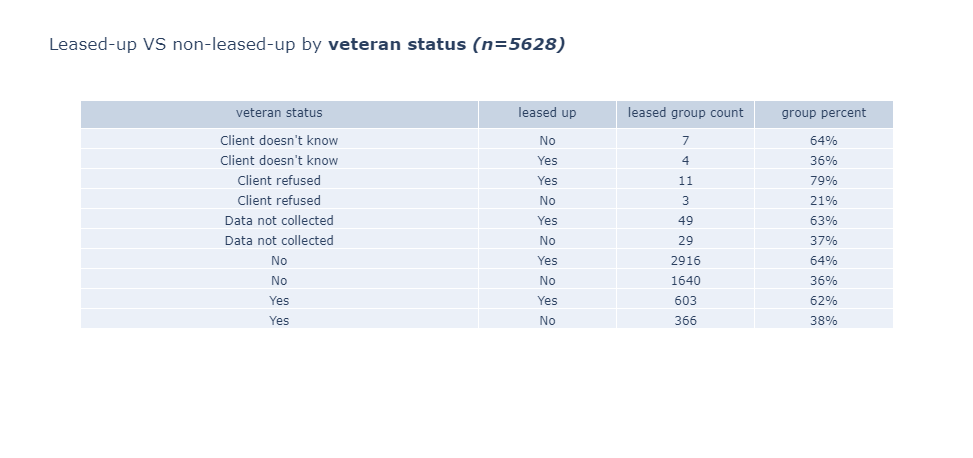

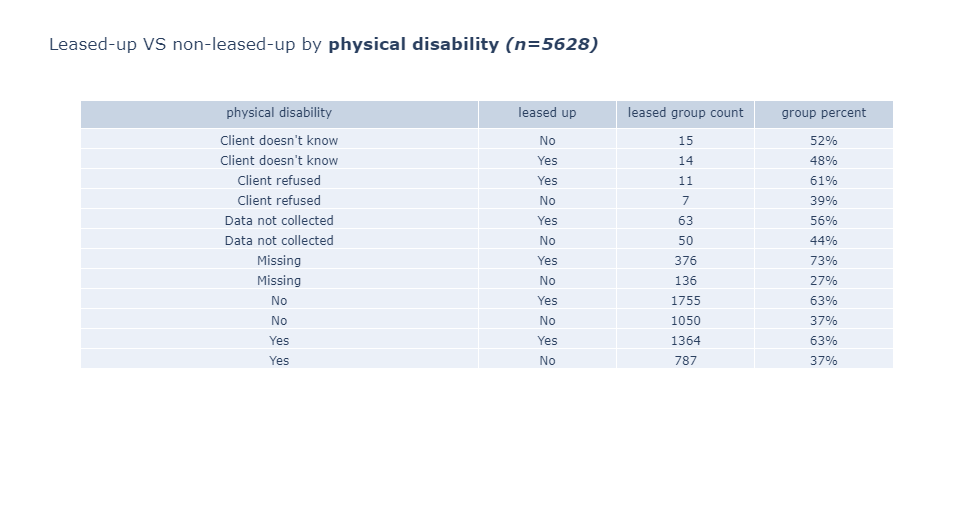

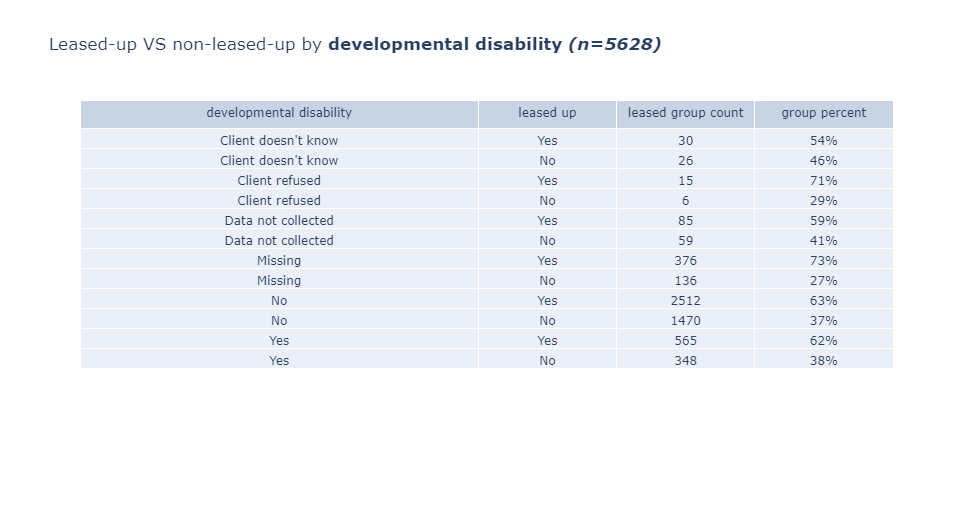

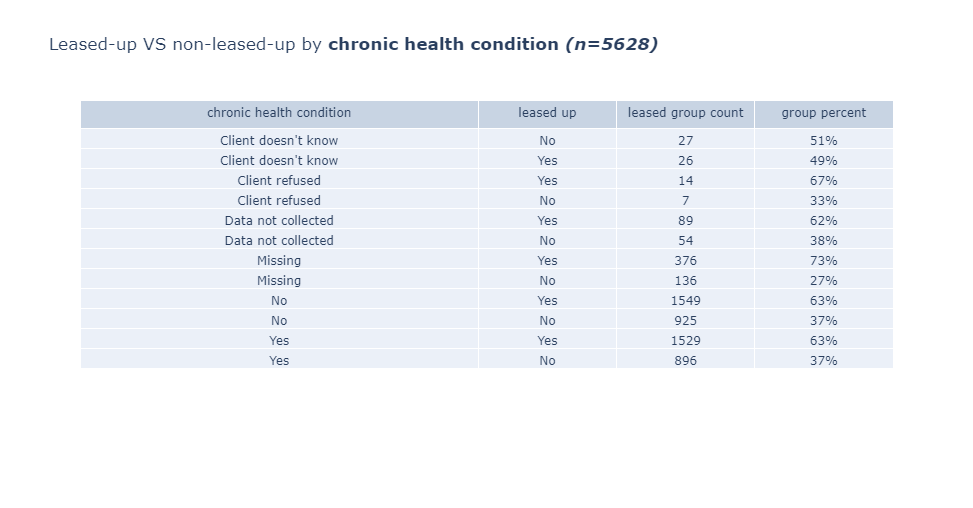

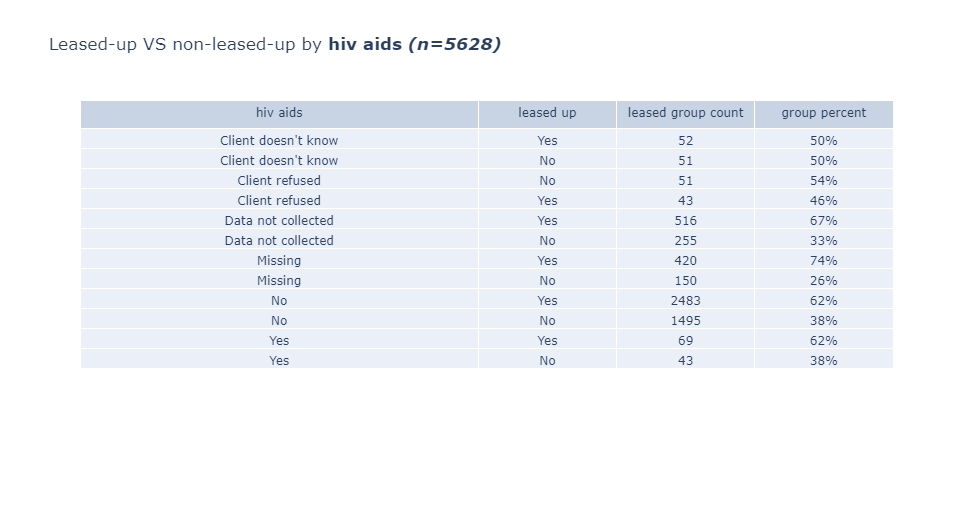

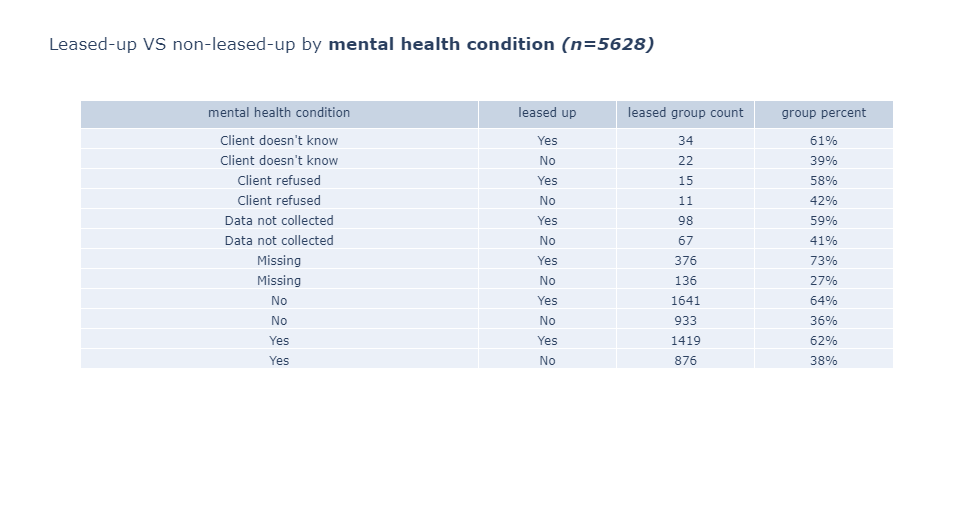

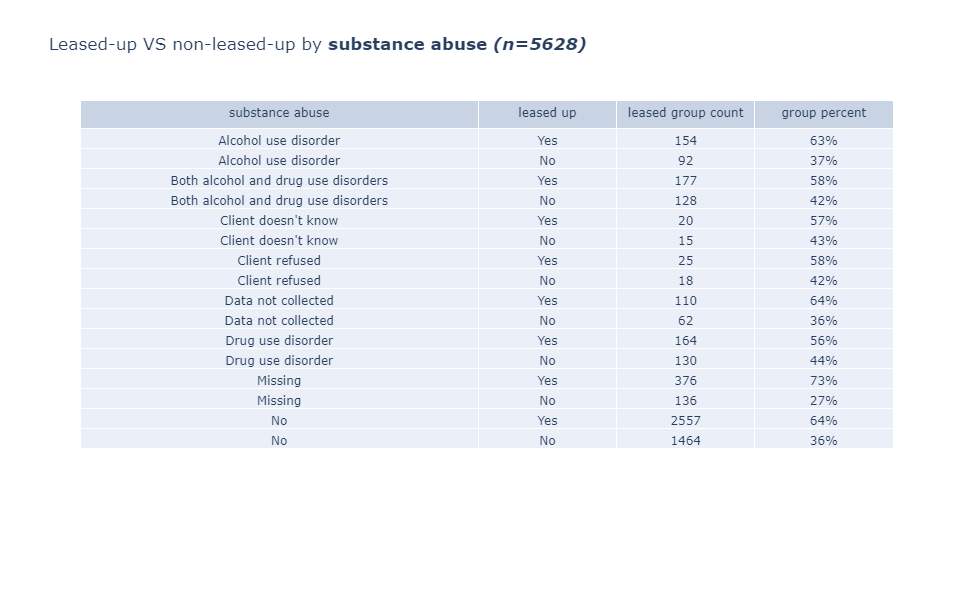

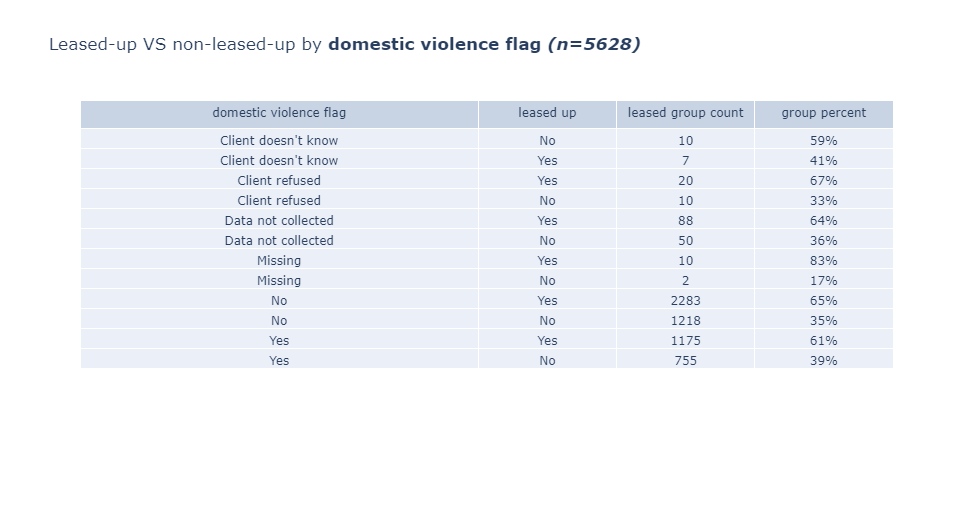

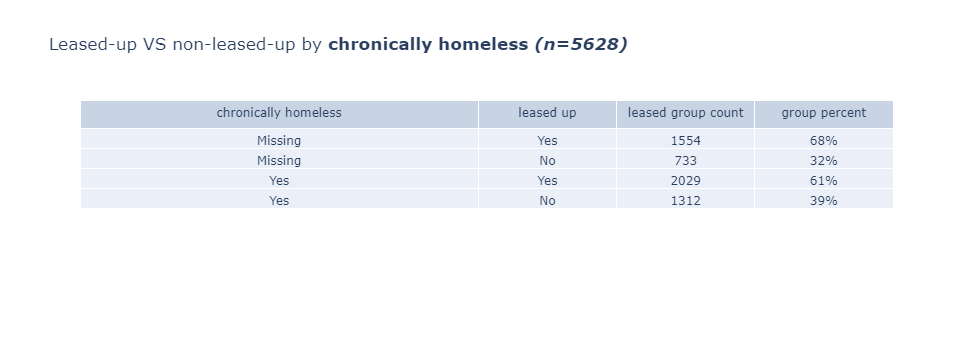

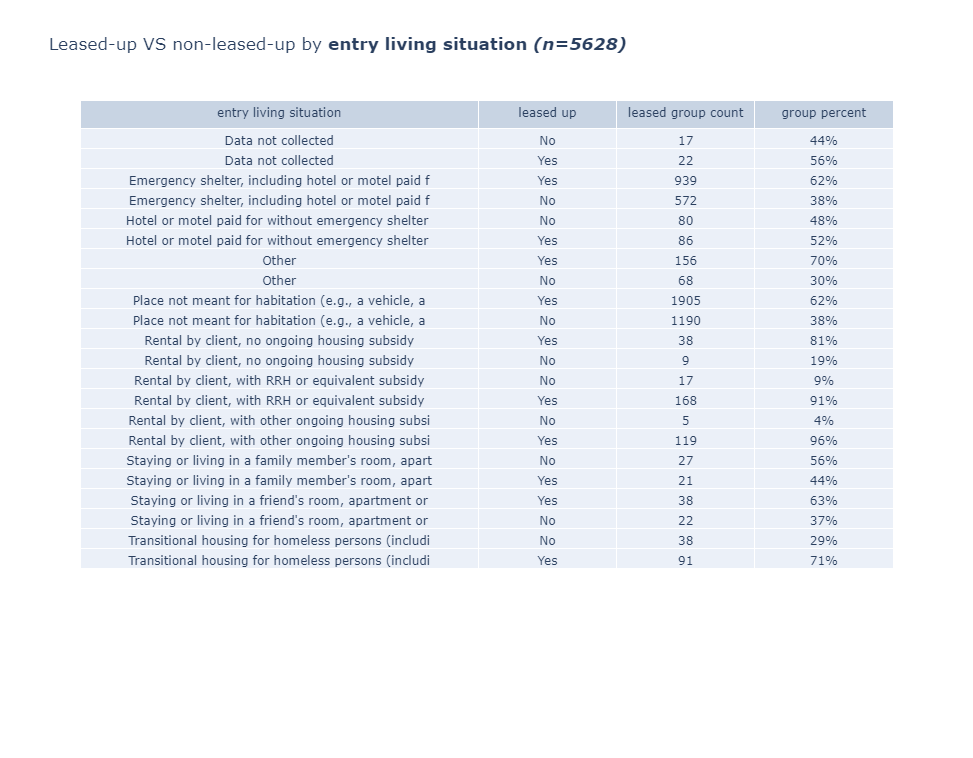

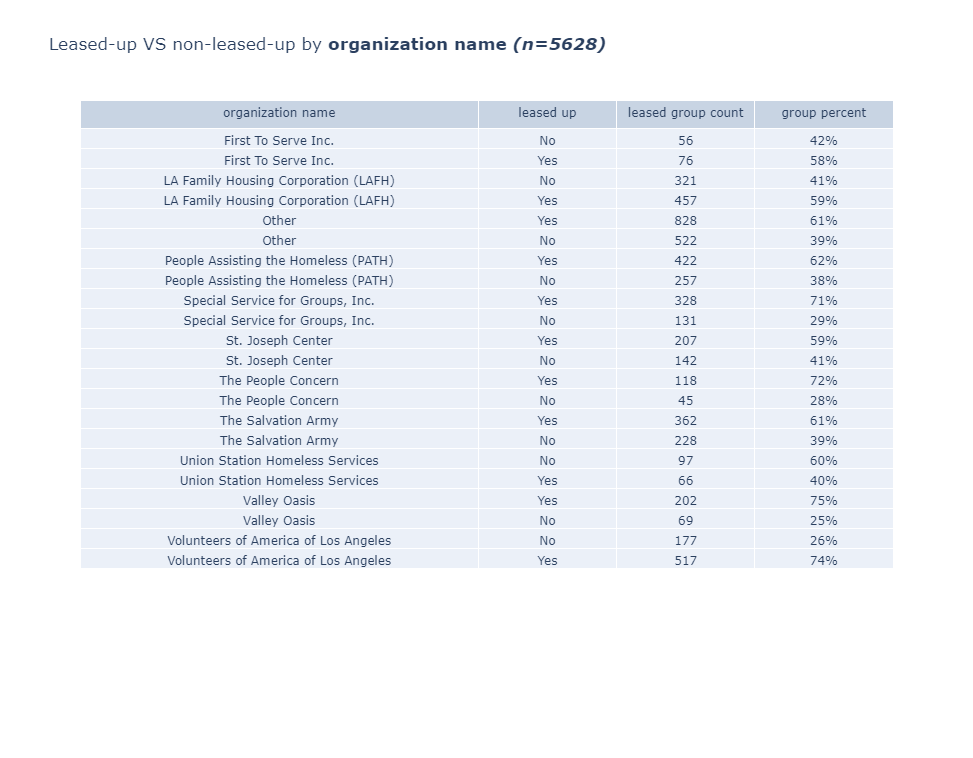

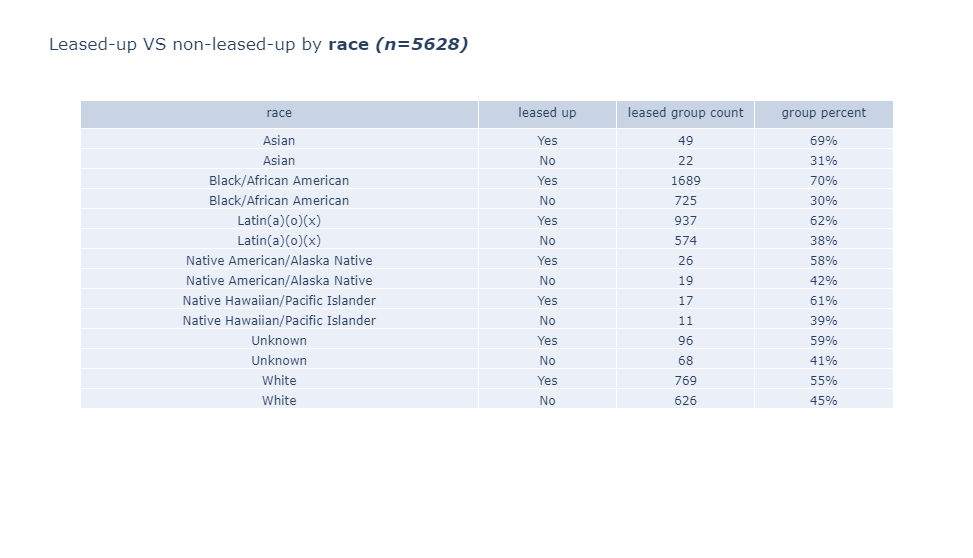

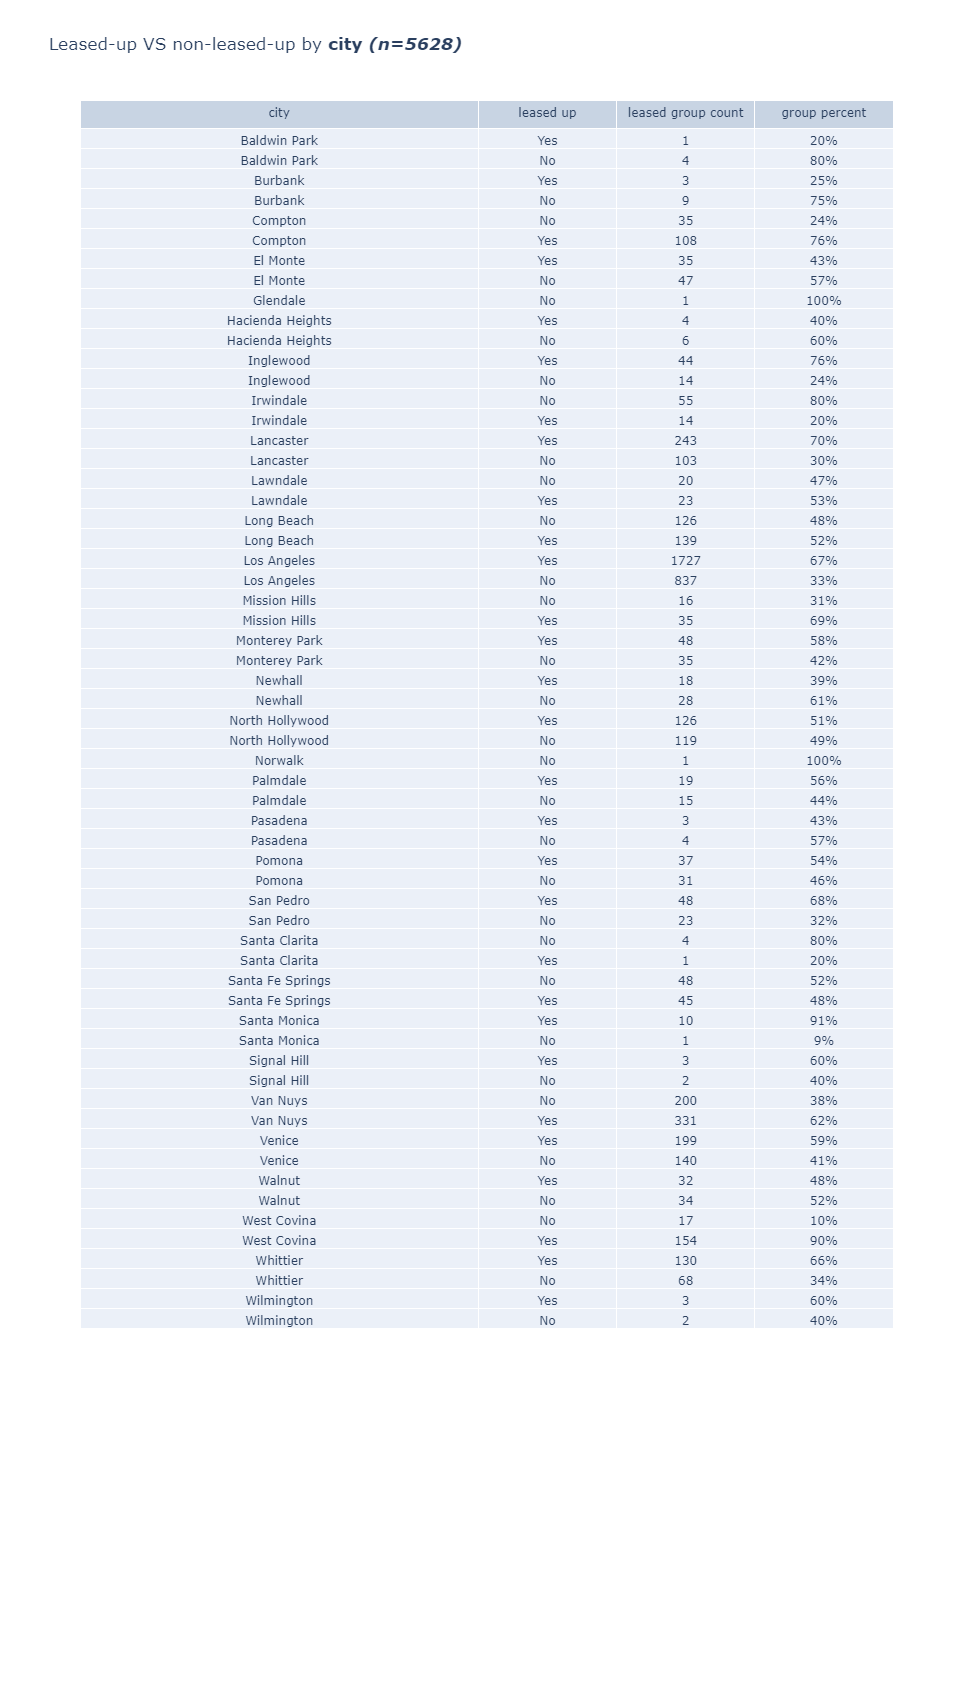

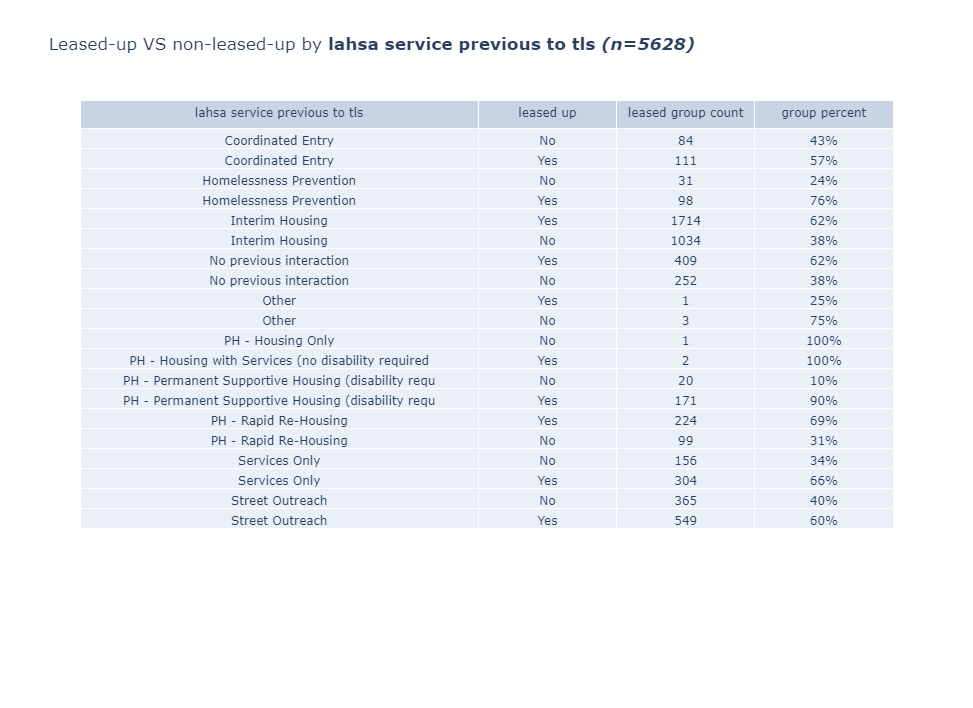

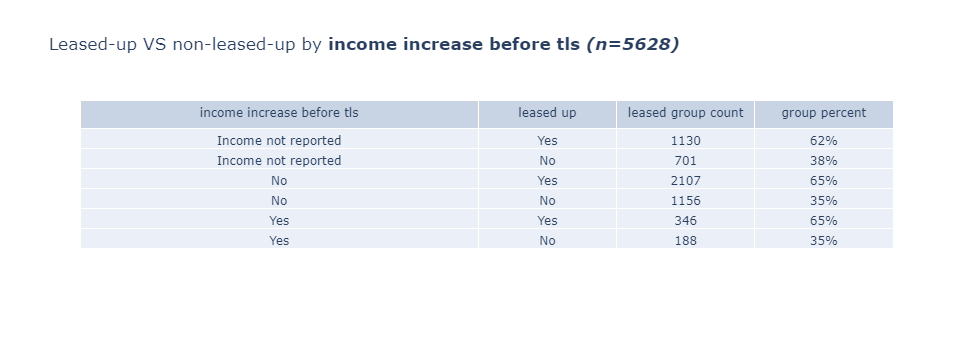

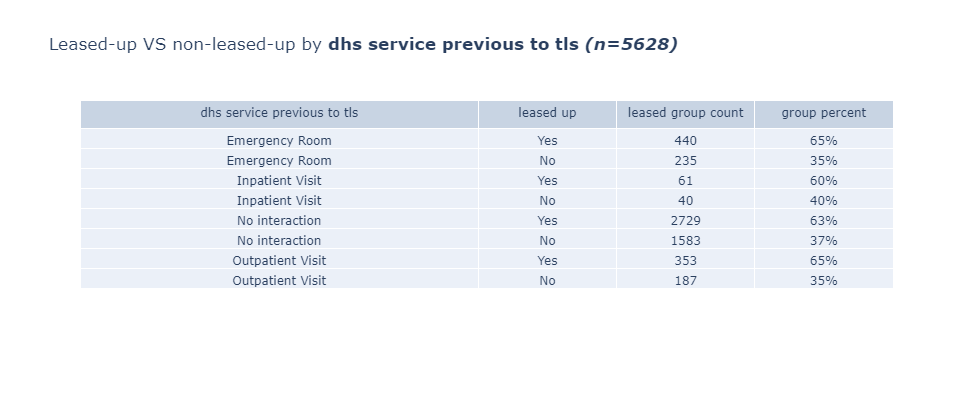

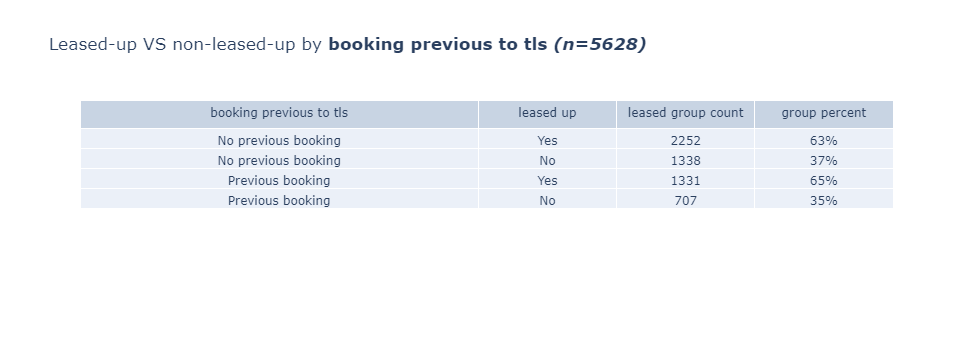

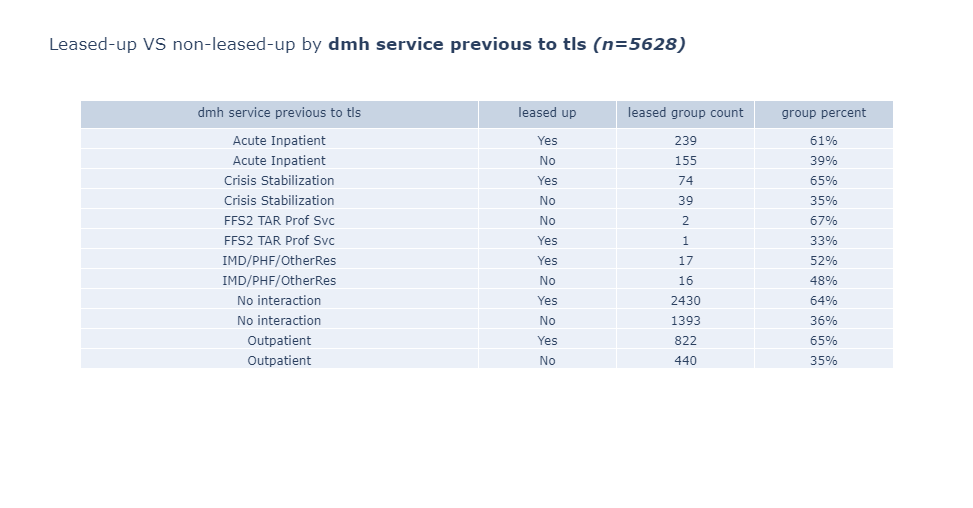

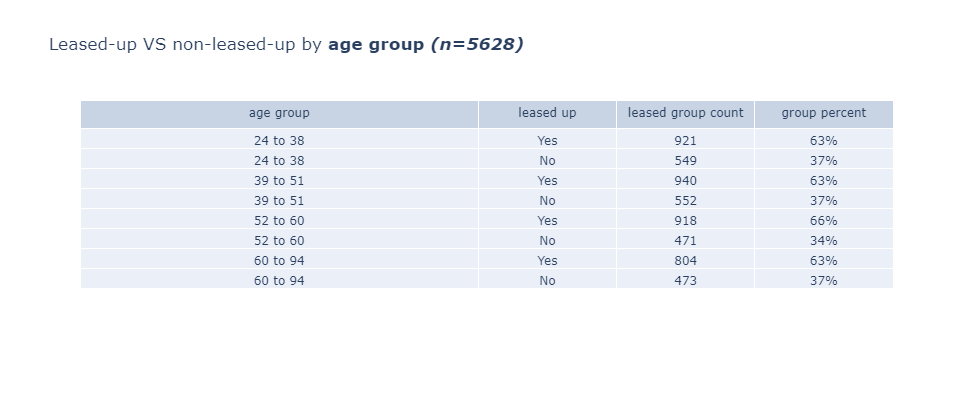

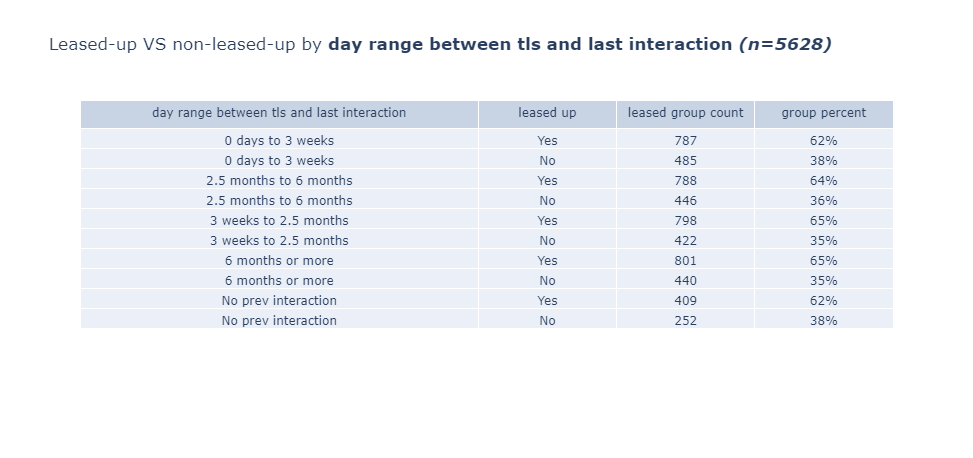

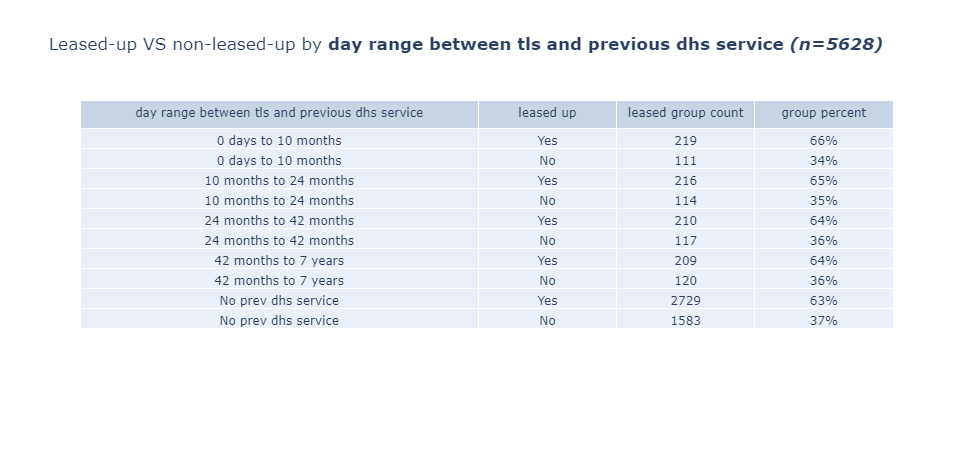

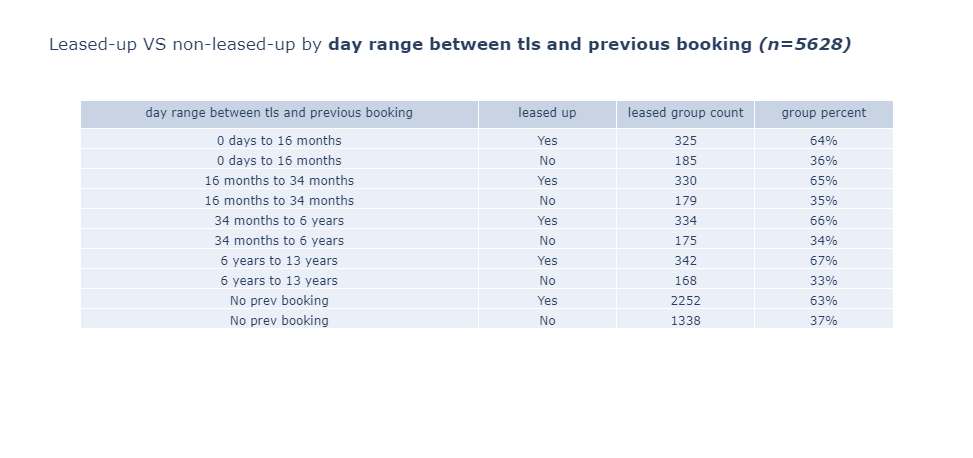

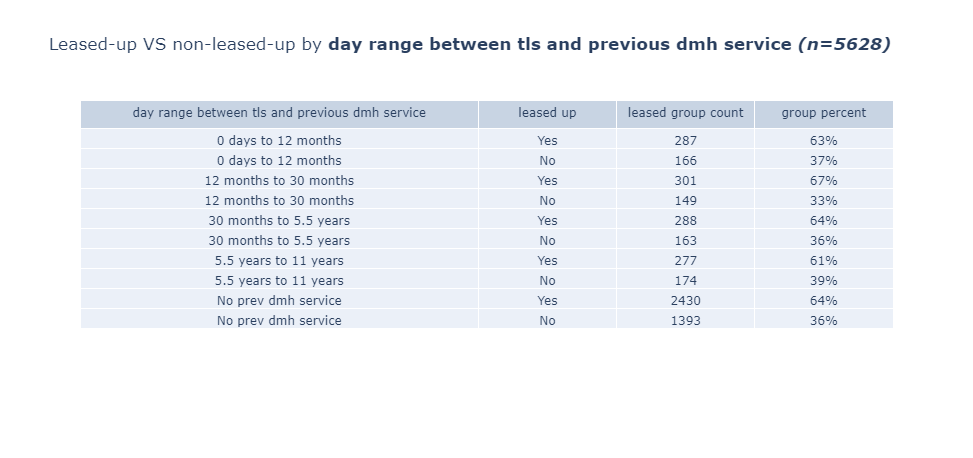

In [8]:
# Creating tables with plotly is tricky!

import plotly.graph_objects as go

# Total obs in sample
n = tls_recipients_clean_for_analysis.shape[0]

# Iterate through columns except 'leased_up'
for label in tls_recipients_clean_for_analysis.drop(['leased_up'], axis=1).columns:
    # Remove group_count because we don't need to show it
    df = tls_recipients_groups[label].drop(['group_count'], axis=1)
    # Sort by group count
    df = df.sort_values(by=[label], ascending=True)
    # Create figure object
    # 1st column wider to fit name and prevent wrapping
    fig = go.Figure(data=[go.Table(columnwidth=[49,17,17,17], \
                        # replace underscore with space in column headers
                        header=dict(values=df.columns.str.replace('_',' ')), \
                        cells=dict(values=[df[label], \
                                          df['leased_up'], \
                                          df['leased_group_count'], \
                                          ['{:.0%}'.format(i) for i in df['group_percent']]]))])
    fig.update_layout(title=dict(text='Leased-up VS non-leased-up by <b>'+label.replace('_',' ')+'<i> (n='+str(n)+')</i></b>'), \
        height=(df.shape[0]*25) + 208,width=1000) # HTML-like format for title
    fig.show()
    # If dir exists, save figure
    if not os.path.exists('../output/'):
        os.makedirs('../output/')
    fig.write_image('../output/'+label+'_table.png')

### Charting

1. we iterate the columns of the original dataframe, dropping `leased_up` again to prevent errors due to duplication.
2. we order the series by column names for the `age_group` and `day_range_between_tls` dataframes, or by count otherwise.
3. we use Plotly to iteratively plot the charts.

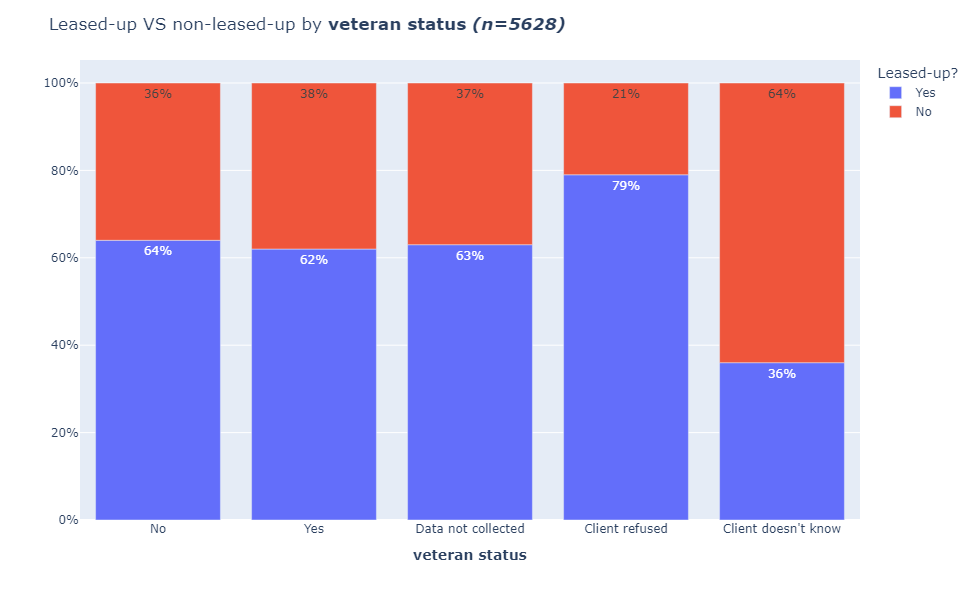

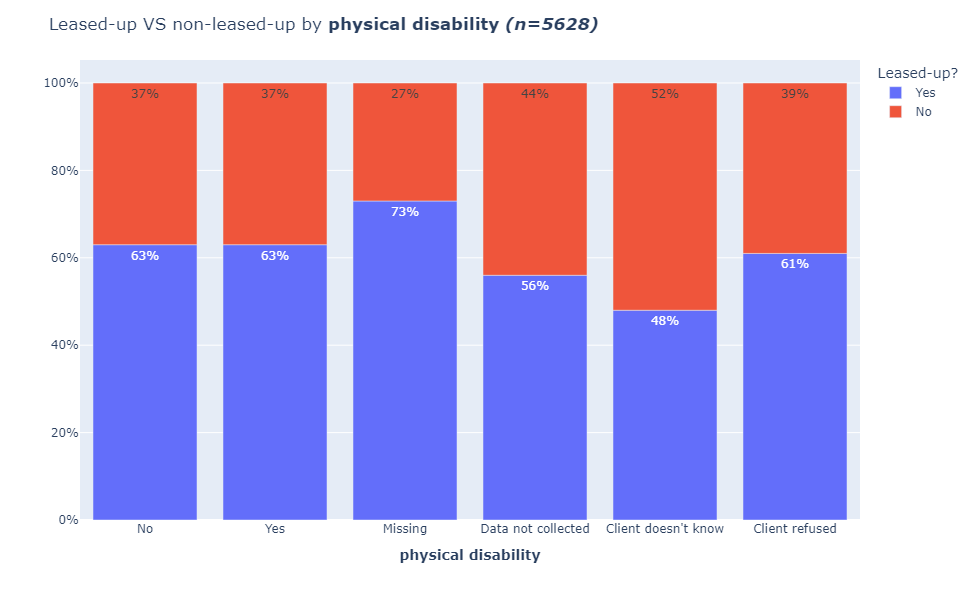

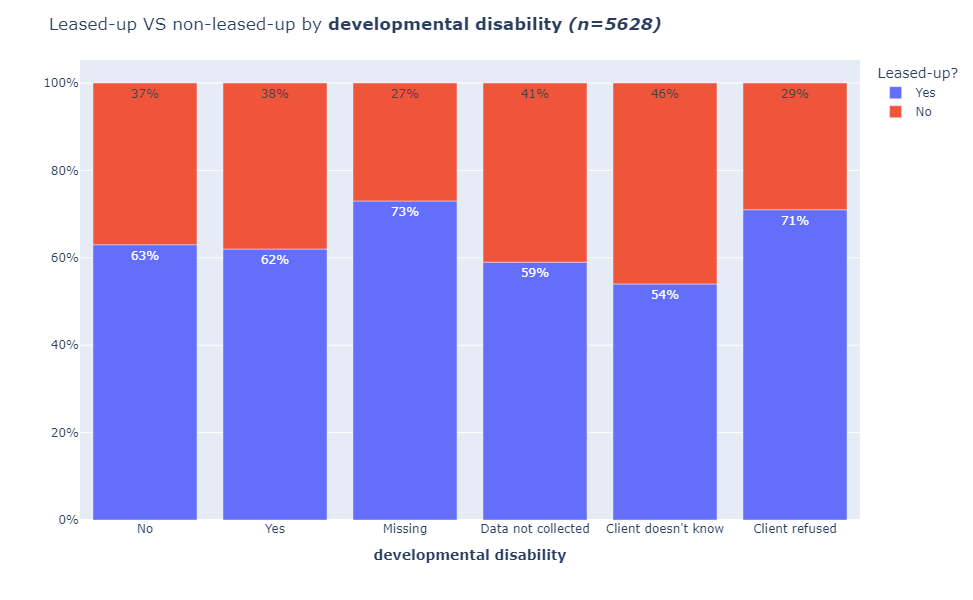

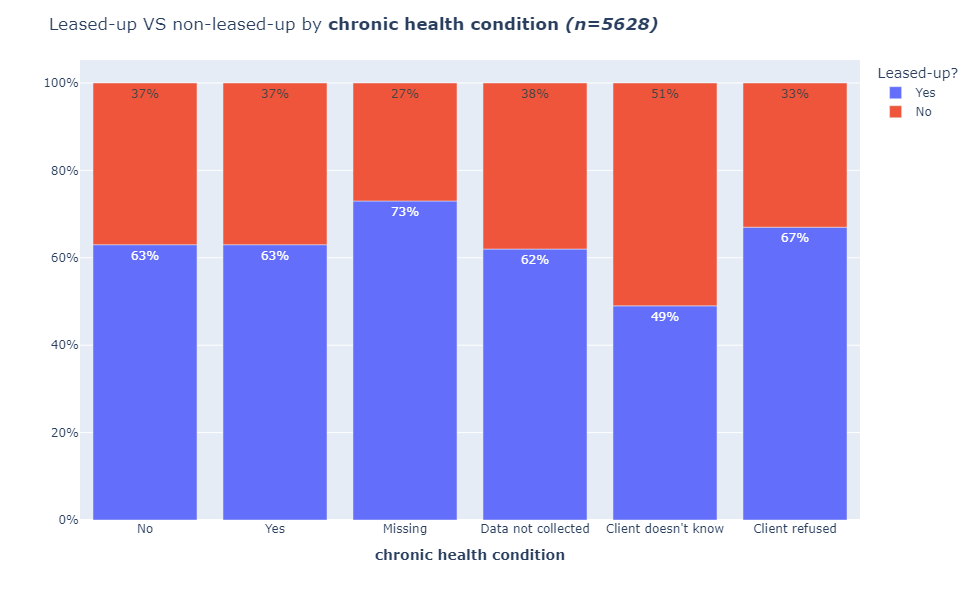

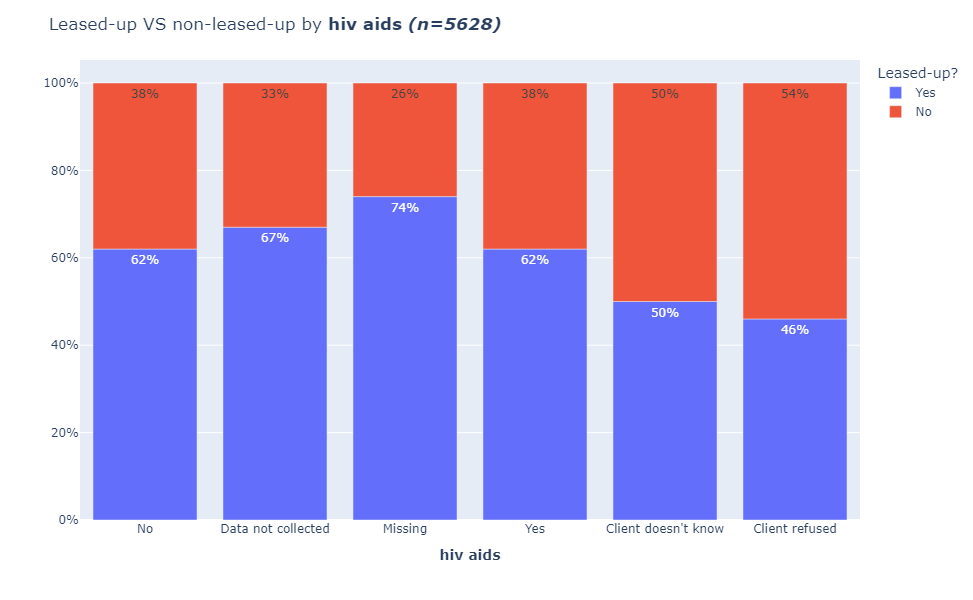

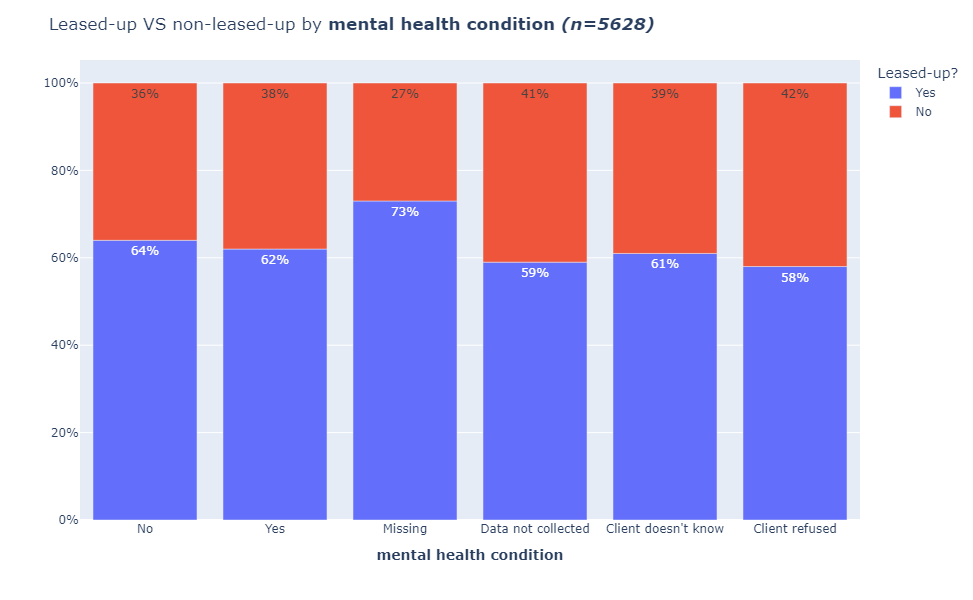

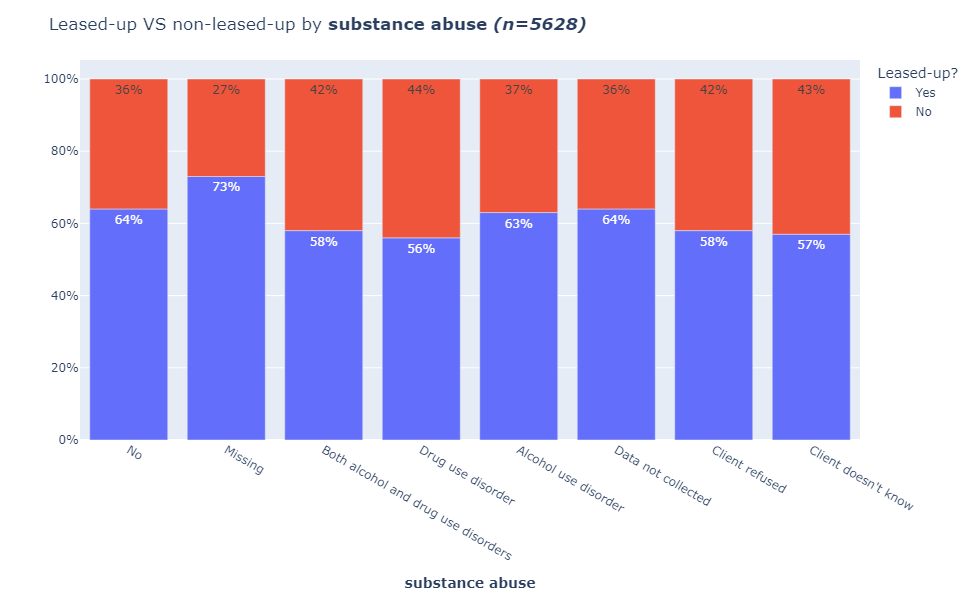

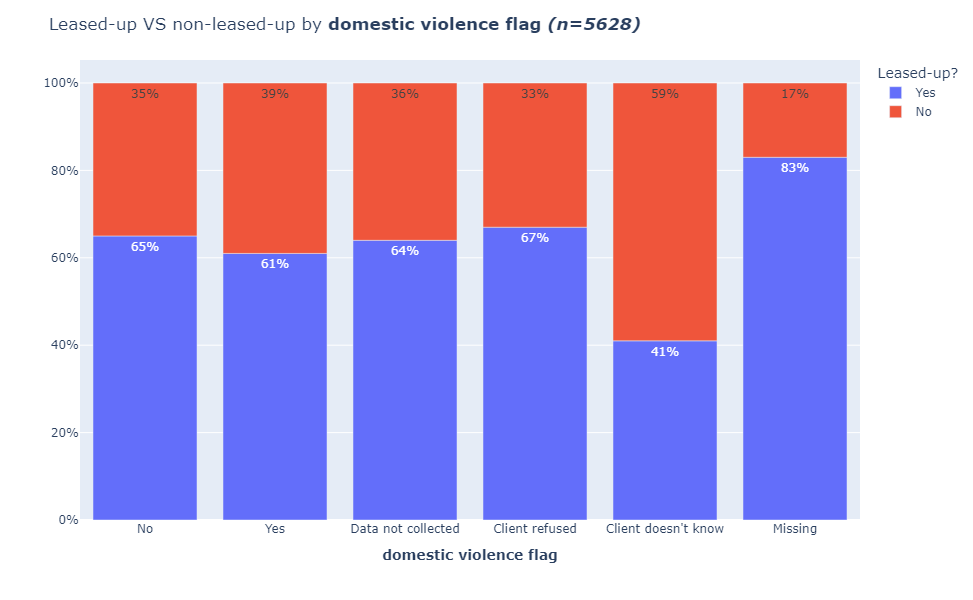

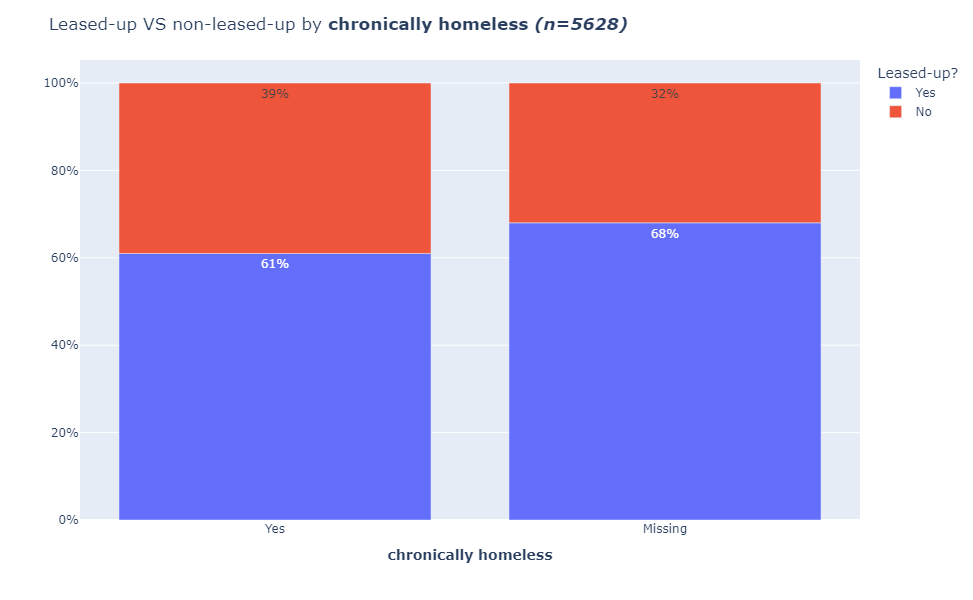

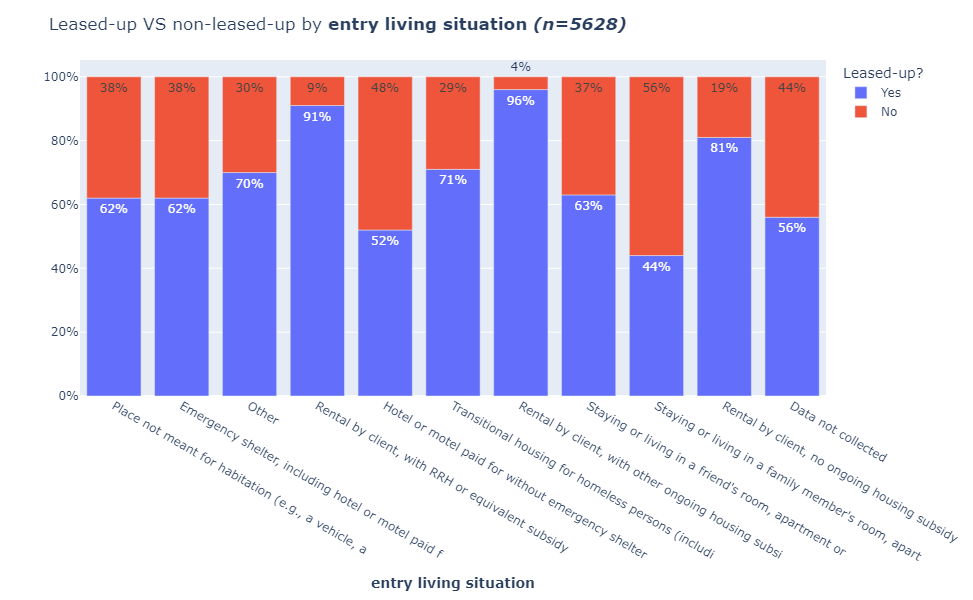

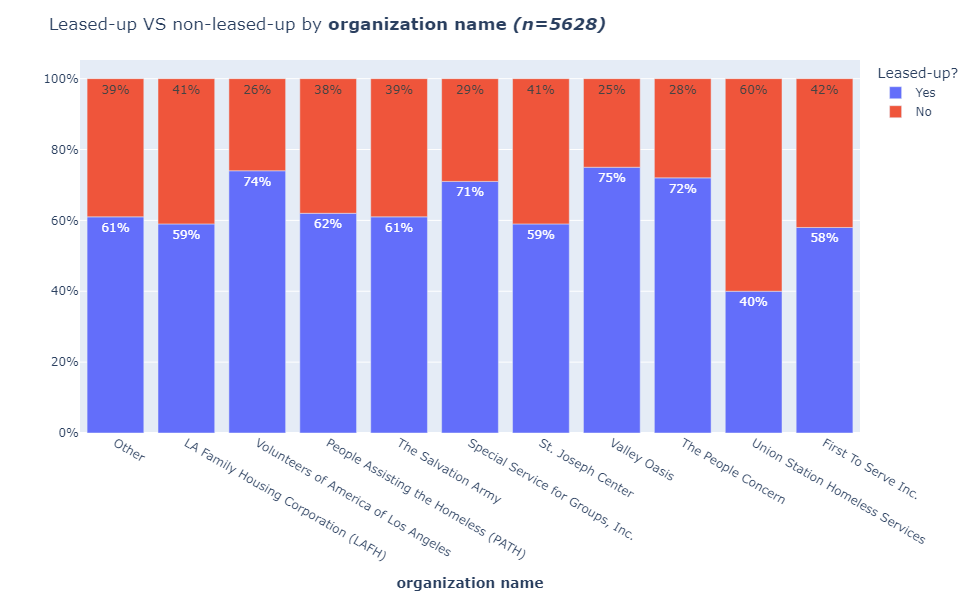

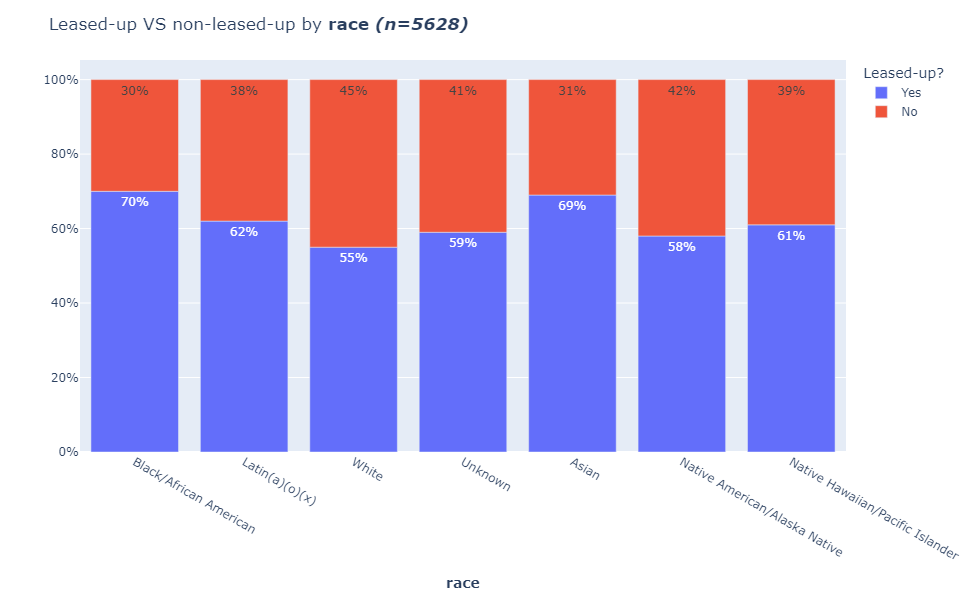

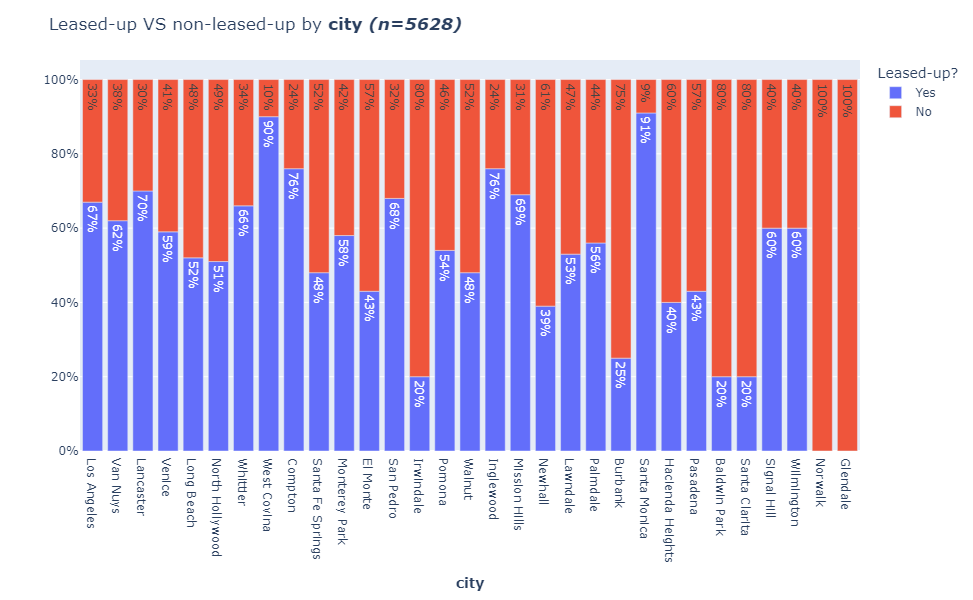

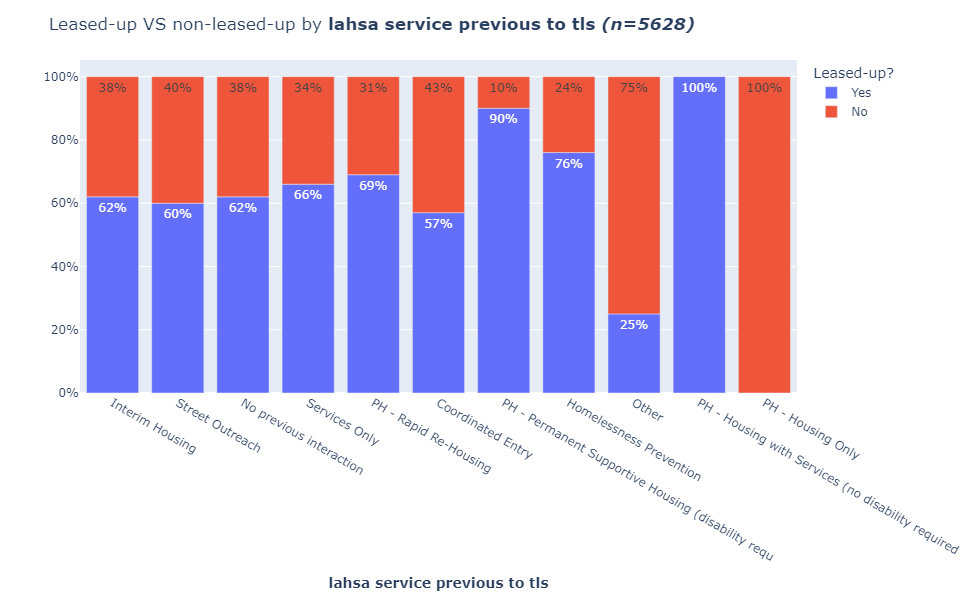

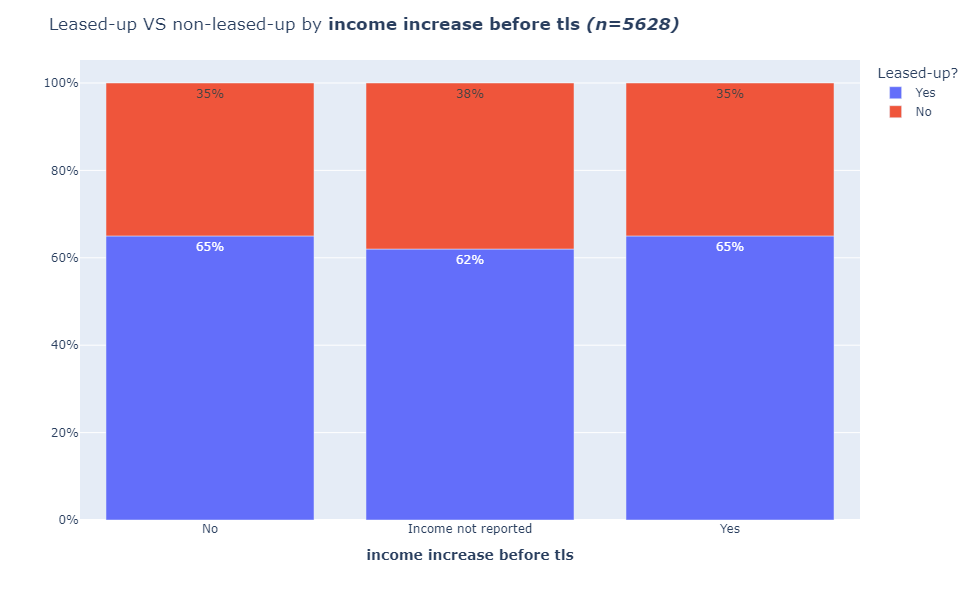

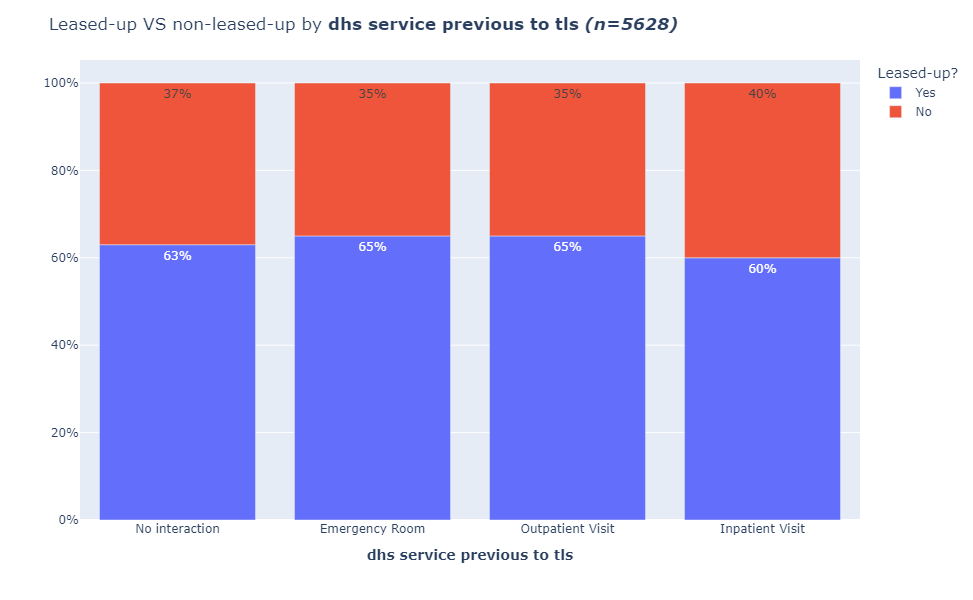

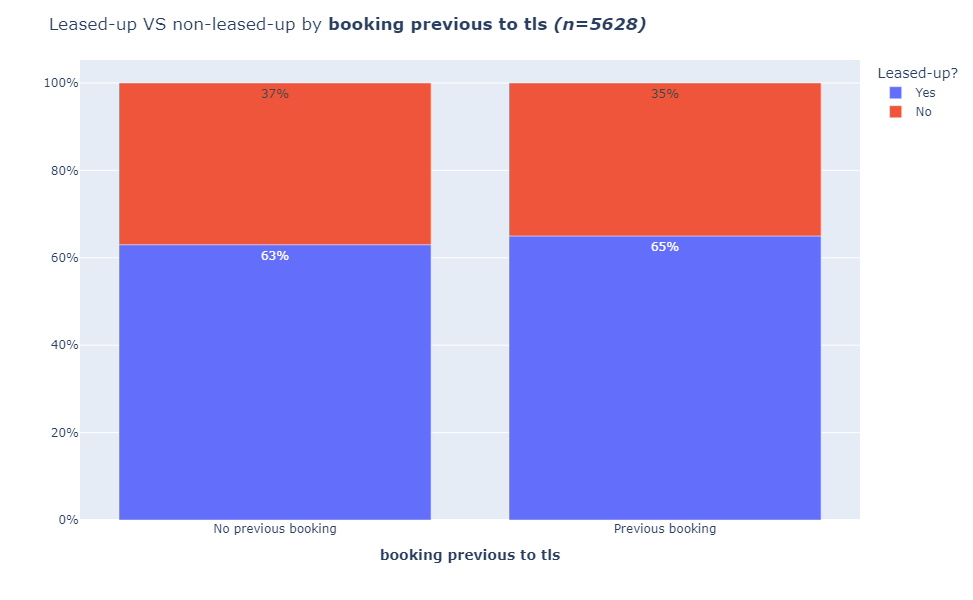

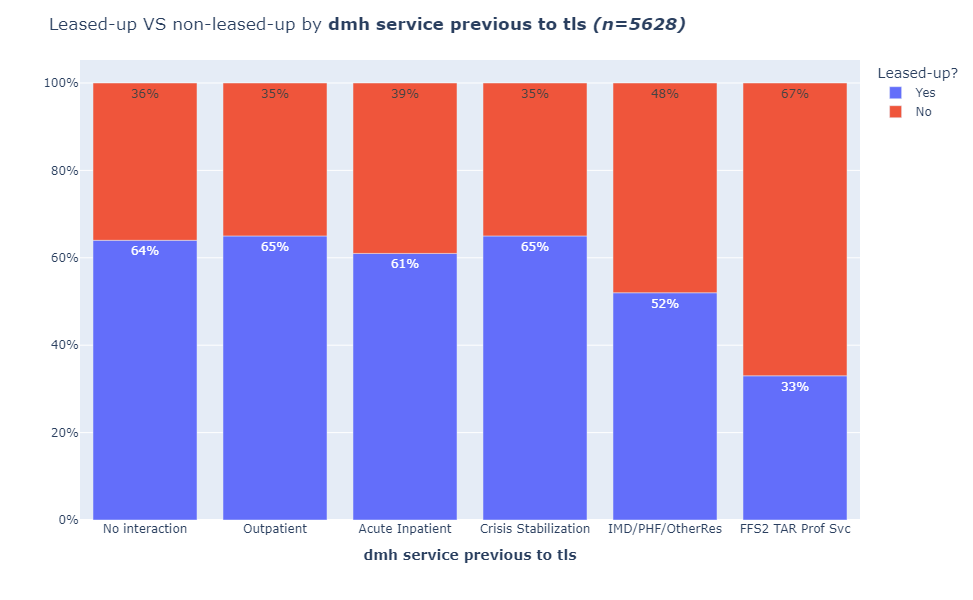

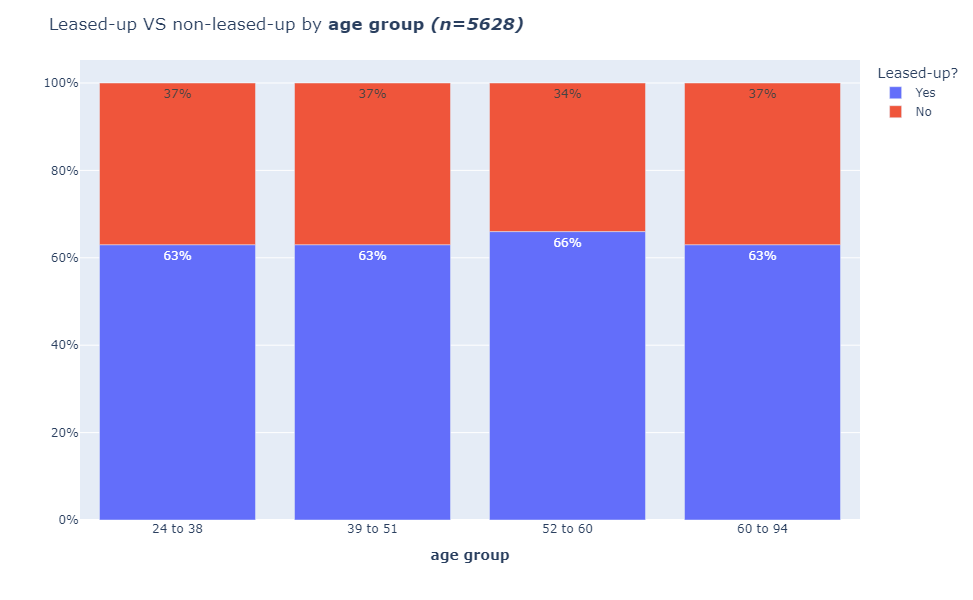

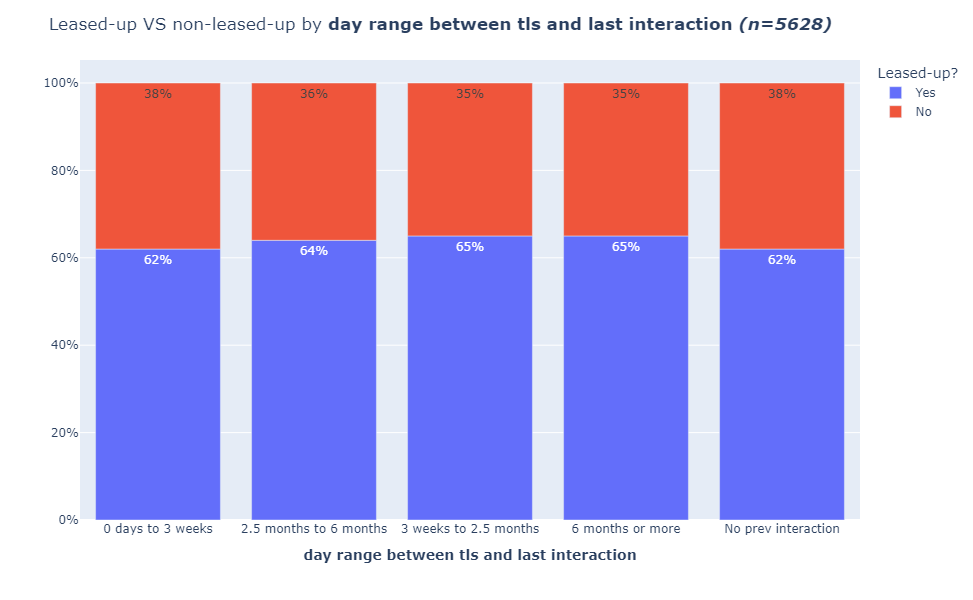

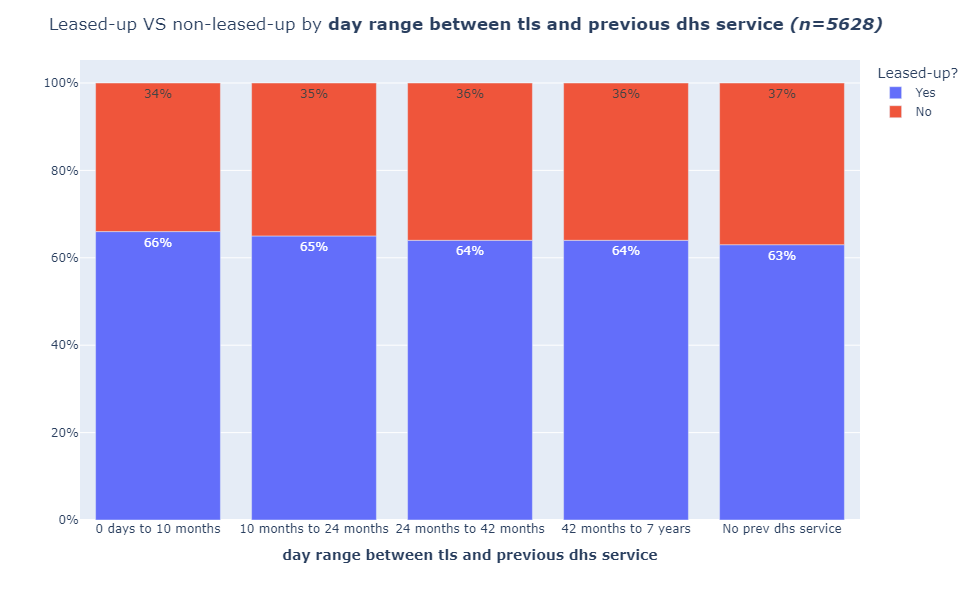

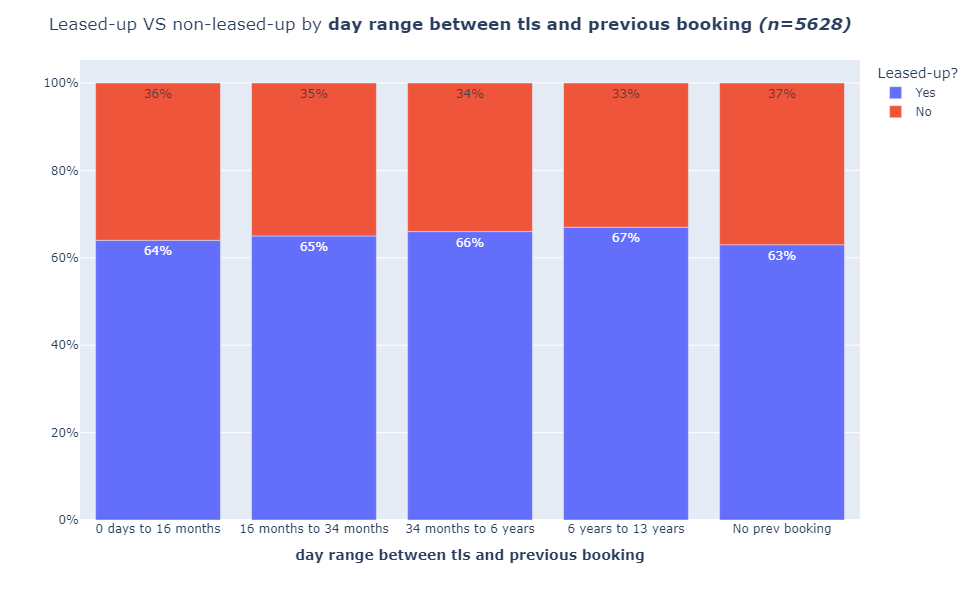

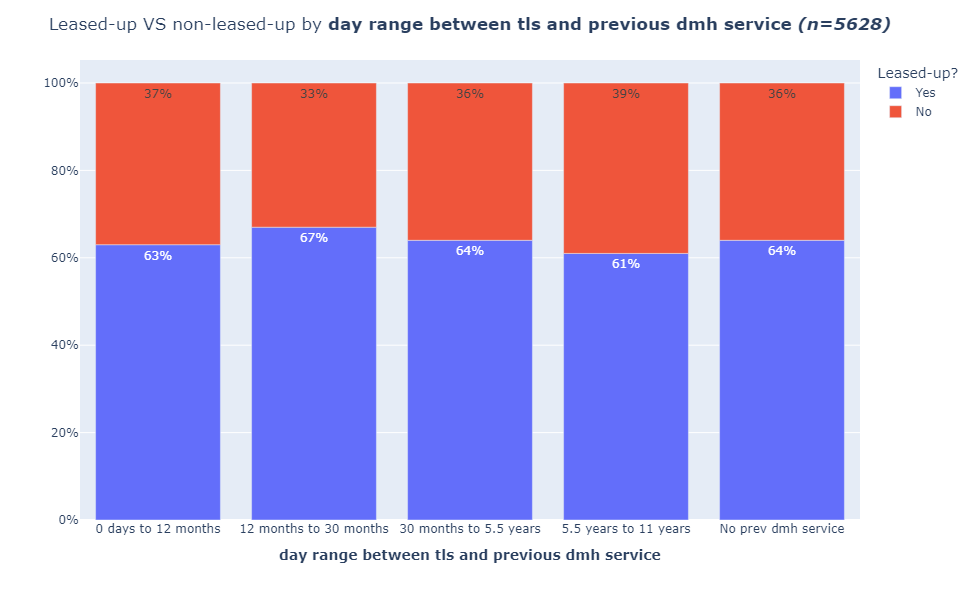

In [9]:
# Charting
# We're dropping leased_up because charting it against itself produces an error
for label in tls_recipients_clean_for_analysis.drop(['leased_up'], axis=1).columns:
    # shorter var name for legibility
    df = tls_recipients_groups[label]
    # Sort age group and day range between TLS X vars so they appear in ascending order
    if label.startswith('age_group') or label.startswith('day_range_between_tls'):
        df = df.sort_values(by=[label], ascending=True)
    else:
        # Otherwise, sort in descending order to go easy on the eyes
        # This worked when charts showed counts, but now that they show percentages,
        # it is useless, since all bars reach 100%
        df = df.sort_values(by=['group_count'], ascending=False)
    # text_auto=False prevents a default value to show inside each bar
    fig = px.bar(df, y = 'group_percent', x = label, color = 'leased_up', text_auto=False, \
                 # if text_auto=False, then we can specity text param with the values
                 # that appear inside each of the bars. We choose percentages
                text=['{:.0%}'.format(i) for i in df.group_percent], orientation='v', \
                height=600)
    # We customize title, axis titles and legends to remove underscores for increased legibility
    # This follows CPL's dataviz guidelines
    fig.update_layout(yaxis_tickformat='.0%', \
                      xaxis_title='<b>'+df.columns[0].replace('_',' ')+'</b>',
                      yaxis_title='',
                      legend_title_text='Leased-up?',
                      title='Leased-up VS non-leased-up by <b>'+df.columns[0].replace('_',' ')+'<i> (n='+str(n)+')</i></b>'
                     )
    fig.show()
    # If dir does not exist, create it before writing the charts out to filesystem
    if not os.path.exists('../output/'):
        os.makedirs('../output/')
    fig.write_image('../output/'+label+'_chart.png')

### Significance of ${\chi}^2$

We create and display a dataframe with the _p-values_ for each of the ${\chi}^2$ tests to examine whether a demographic feature has any bearing on the distinction between leased and non-leased up groups.

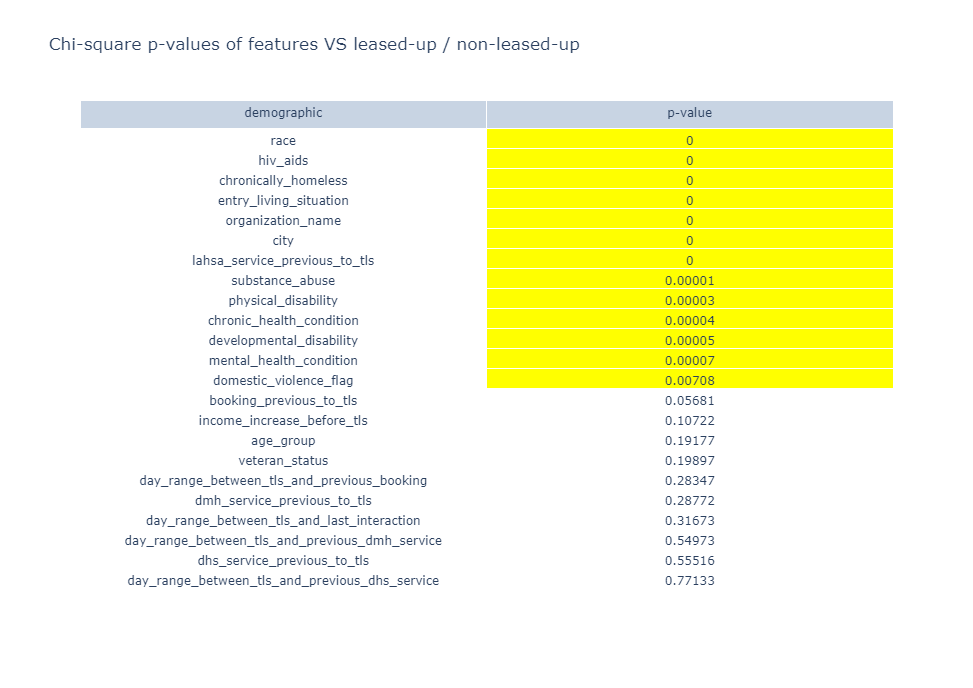

In [10]:
# We turn the dictionary with the p values from the chi-square tests into a dataframe
tls_recipients_diff_significance = pd.DataFrame.from_dict(diff_significance_dict, orient='index') \
    .sort_values(by=[0], ascending=True)
# Reset index because we need the feature names as column
tls_recipients_diff_significance = tls_recipients_diff_significance.reset_index()
# Assign column names
tls_recipients_diff_significance.columns = ['demographic','p-value']
# Create fillcol variable as a list of hex-coded colors. This will go into plotly to 
# indicate the color of each fill. Color depends on p-value. If <= .05, cel collor will be yellow
fillcol = ['#FFFF00' if c <= 0.05 else '#FFFFFF' for c in tls_recipients_diff_significance['p-value']]
# Create table figure...
fig = go.Figure(data=[go.Table( \
                        # ...with column names as headers
                        header=dict(values=tls_recipients_diff_significance.columns), \
                        # and demographic and p-values as cells
                        cells=dict(values=[tls_recipients_diff_significance['demographic'], \
                                           tls_recipients_diff_significance['p-value']], \
                                   # with fill as indicated by the fillcol variable
                                  fill=dict(color=['white', fillcol]))) \
                     ])
# Assign table title
fig.update_layout(title=dict(text='Chi-square p-values of features VS leased-up / non-leased-up <b>'),
    height=688,width=800)
fig.show()
# If directory does not exist, create it before saving figure
if not os.path.exists('../output/'):
    os.makedirs('../output/')
fig.write_image('../output/chi-square-significance.png')

This method of feature selection is flawed, especially in linear models, since we are _emulating_ a stepwise regression feature selection mechanism, and that has its limitations:

1. Causal inference assumes the model is pre-specified, meaning that all of our reality should go into it before looking at the model's p-values.
2. Removing low p-values from our data before modeling, and then making any decision on the resulting coeffs due to their p-values is flawed. The variables that are left after each _pass_ would have smaller p-values in the complete model, but since we are removing some each time, their p-value is _artificially_ increased.
3. In general, stepwise regression's coeffs are biased high, and the standard errors biased low. This bias allows for variables that may be irrelevant to become part of the model.
4. The higher the number of predictors, the greater these shortcomings are exacerbated.

### Logistic Reggression Classifier to verify relevant factors

#### Remove colinear features

`city` and `organization_name` can be deemed colinear since SPAs (and hence organizations) operate within the geographic area of a city, so they will also be removed before input to the linear model.

Categoricals derived from numeric will also be removed, and the original numeric features will be kept.

`entry_date` will be removed because the spine is constrained to 2021 enrollments.

Finally, `destination` is not relevant because we are concerned only with TLS enrollment and whatever happened before, not after.

Write out CSV file for proper separation of concerns and more agile model exploration.

In [11]:
tls_recipients_clean_for_modeling = tls_recipients_no_na.drop(['eid','age_group','project_type','interaction_date_prev_to_tls', \
                                          'day_range_between_tls_and_last_interaction', \
                                          'day_range_between_tls_and_previous_dmh_service','day_range_between_tls_and_previous_booking',\
                                          'day_range_between_tls_and_previous_dhs_service',\
                                          'destination','entry_date','project_name','city'], axis = 1)
tls_recipients_clean_for_modeling.to_csv('../output/tls_recipients_2021_clean_for_model.csv')

While `entry_living_situation` and `lahsa_service_previous_to_tls` may appear colinear, having had access to a LAHSA service does not imply that a client had a change in housing situation previous to being enrolled in TLS thanks to that intervention, so we are keeping it.

#### Classification with `h2o` 

We are using h2o instead of scikit-learn because:

1. sklearn forces one-hot encoding of categorical vars for all models, thus risking overfitting, and making explanation a hassle, since it is quite difficult to go back from encoded vars to the original ones.
2. h2o's explanation mechanism privileges global explanations rather than explanations that are local to individual predictions, like those enabled by LIME.

H2O is an open source ML library with a Java-backend privileging statistical practices over CS. Trevor Hastie and Rob Tibshirani of "Elements of Statistical Learning" fame, preside the company's board of directors.

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -----------------------------
H2O_cluster_uptime:         2 days 0 hours 35 mins
H2O_cluster_timezone:       America/Los_Angeles
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.44.0.3
H2O_cluster_version_age:    2 months and 15 days
H2O_cluster_name:           jramoscardona
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    27.48 Gb
H2O_cluster_total_cores:    16
H2O_cluster_allowed_cores:  16
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.11.7 final
--------------------------  -----------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GLM_model_python_1709601358988_144919

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.452533376305162
       No    Yes    Error    Rate
-----  ----  -----  -------  --------------
No     15    609    0.976    (609.0/624.0)
Yes    2     1047   0.0019   (2.0/1049.0)
Total  17    1656   0.3652   (611.0/1673.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

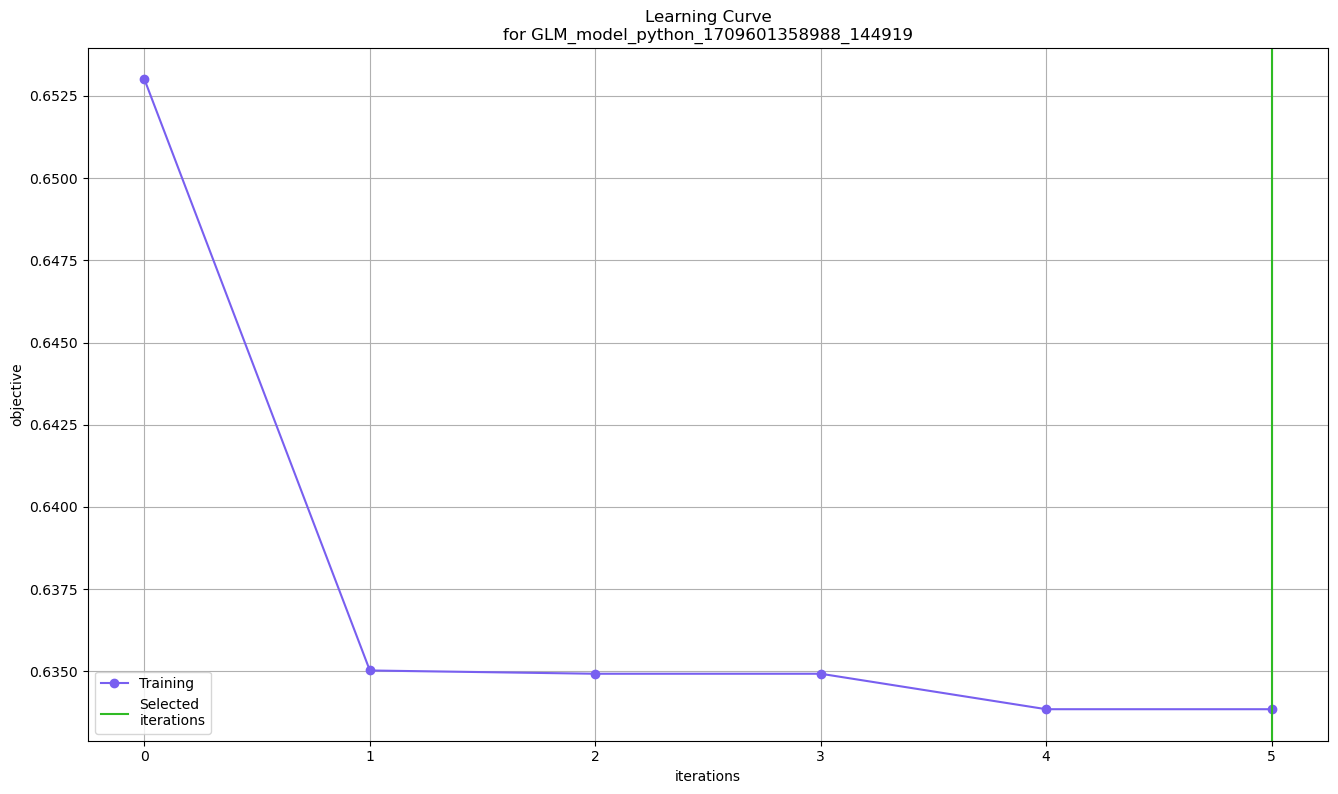

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

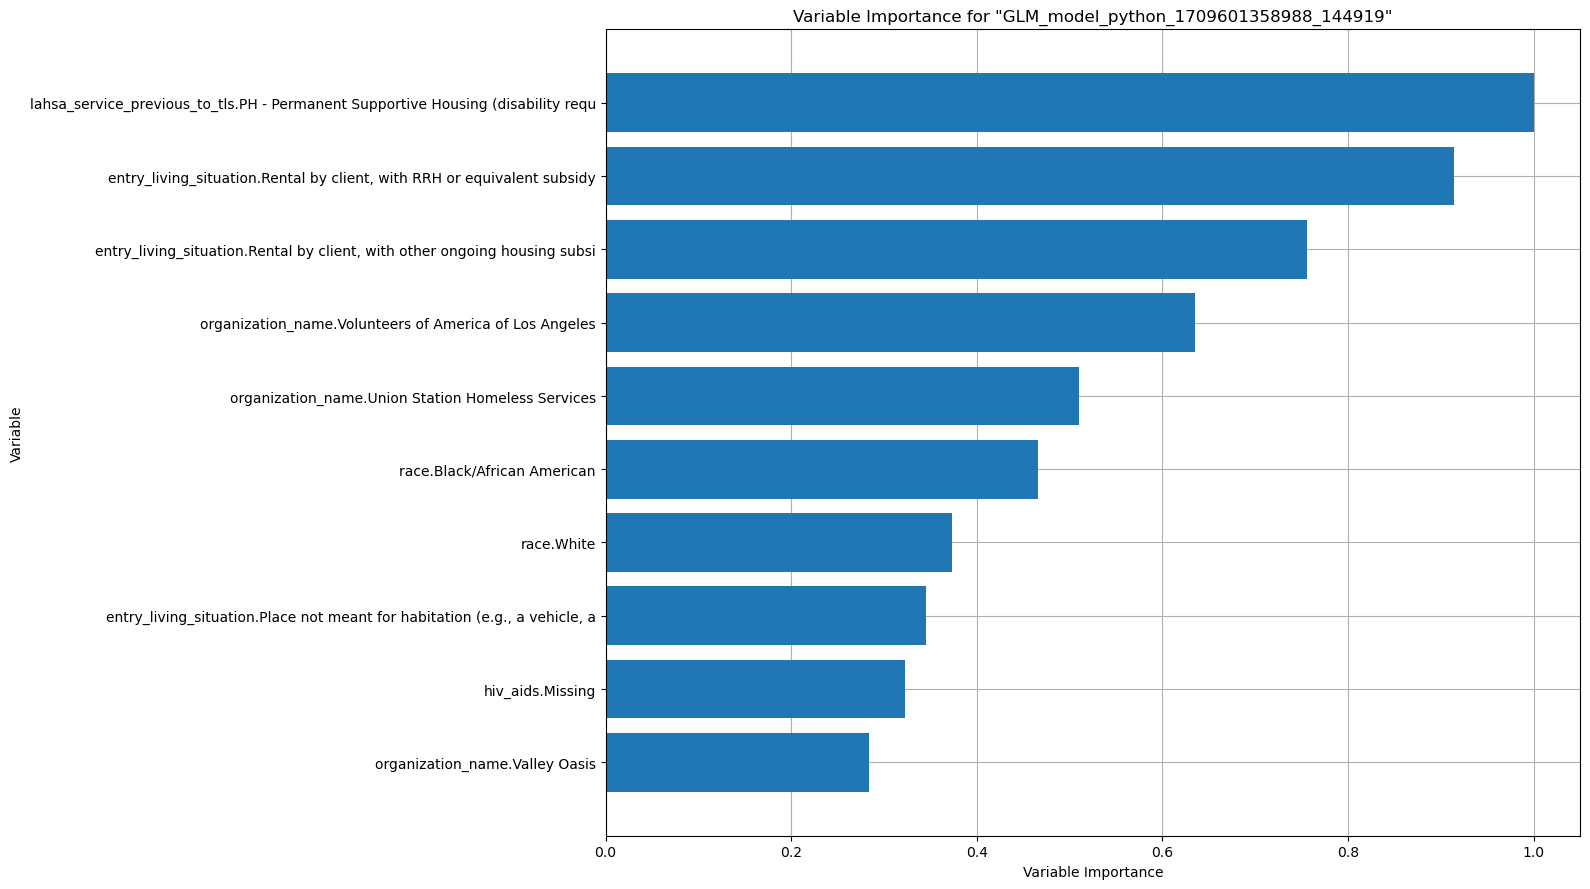

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

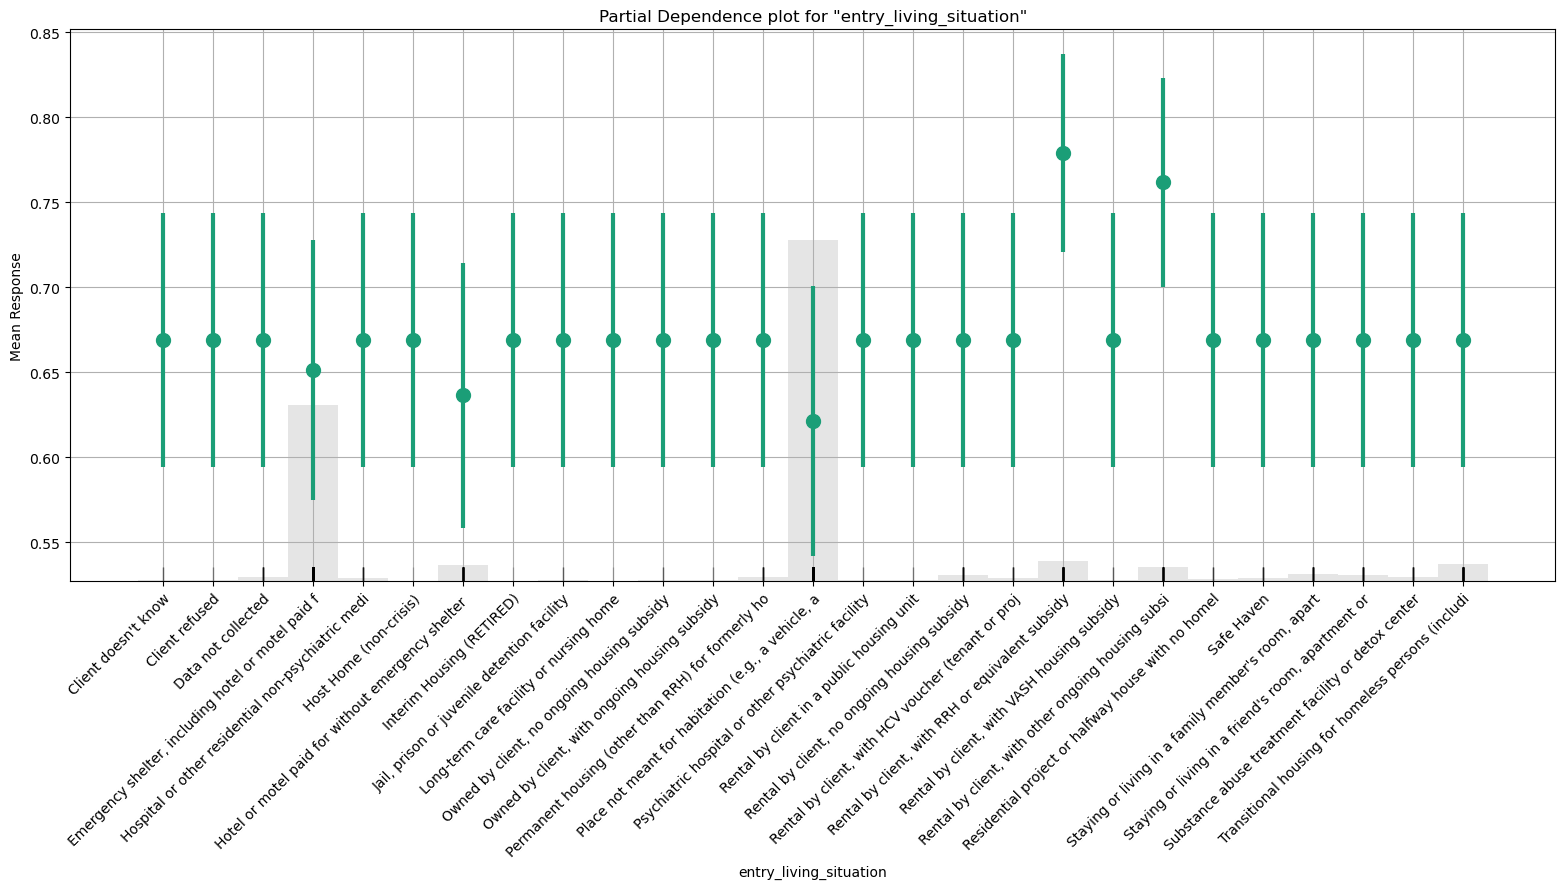

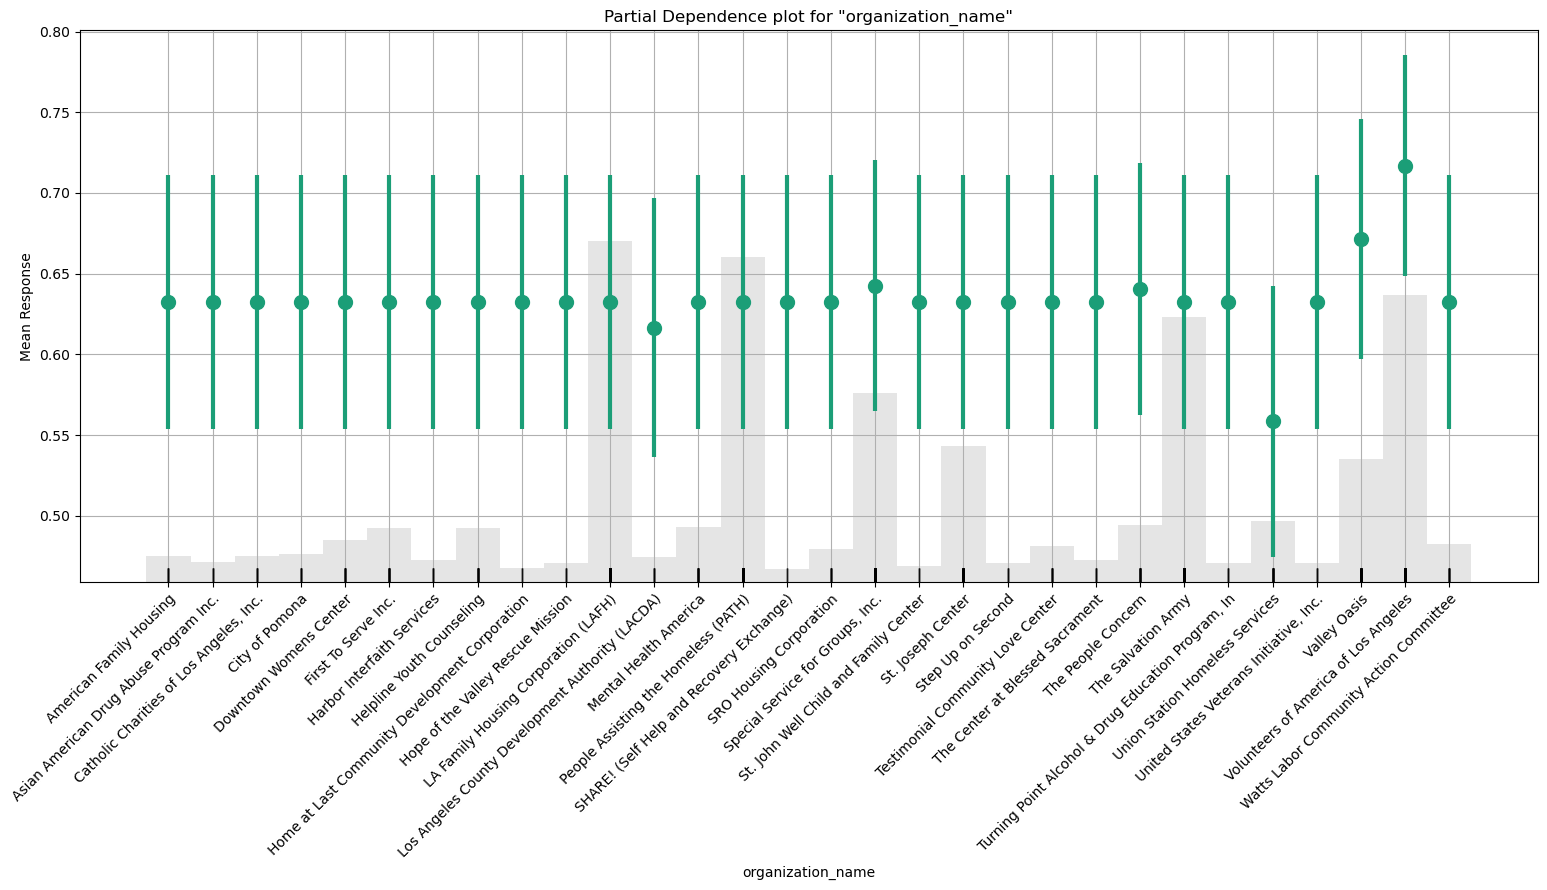

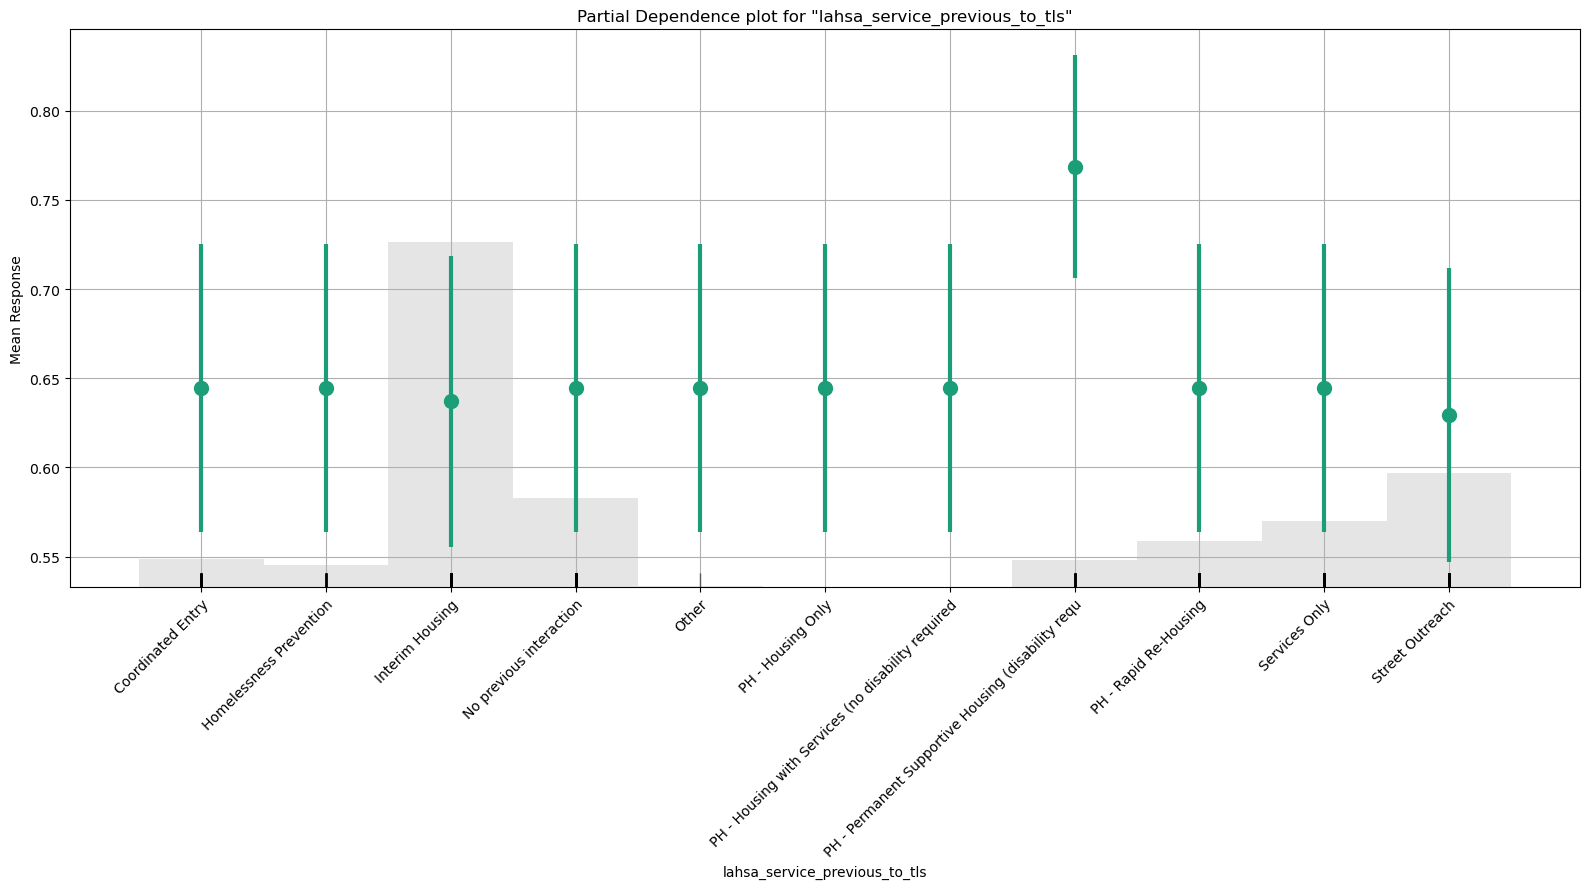

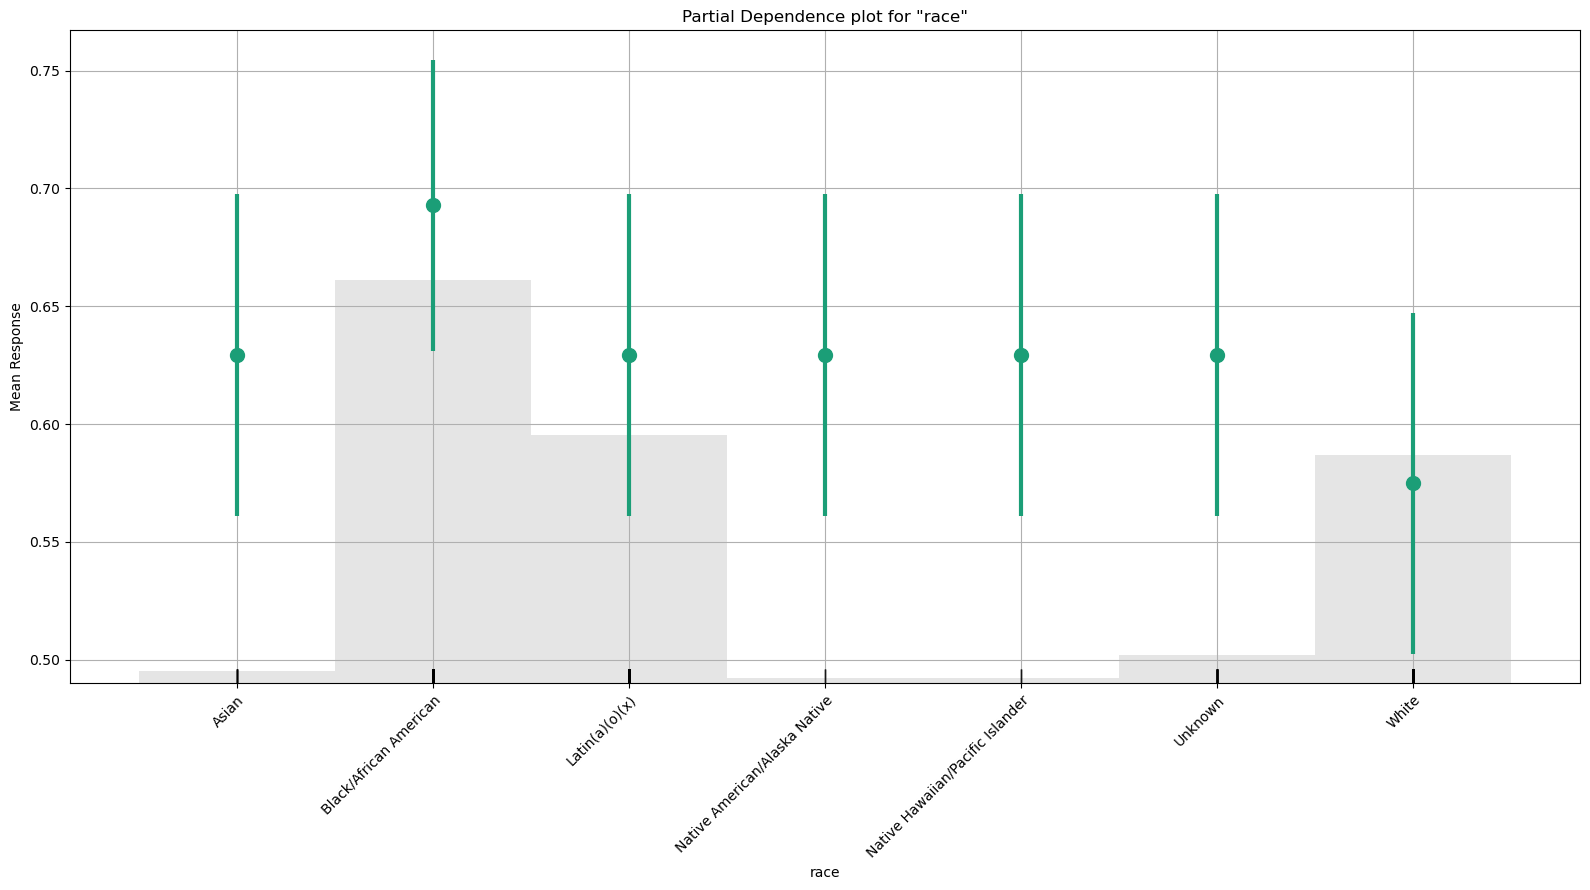

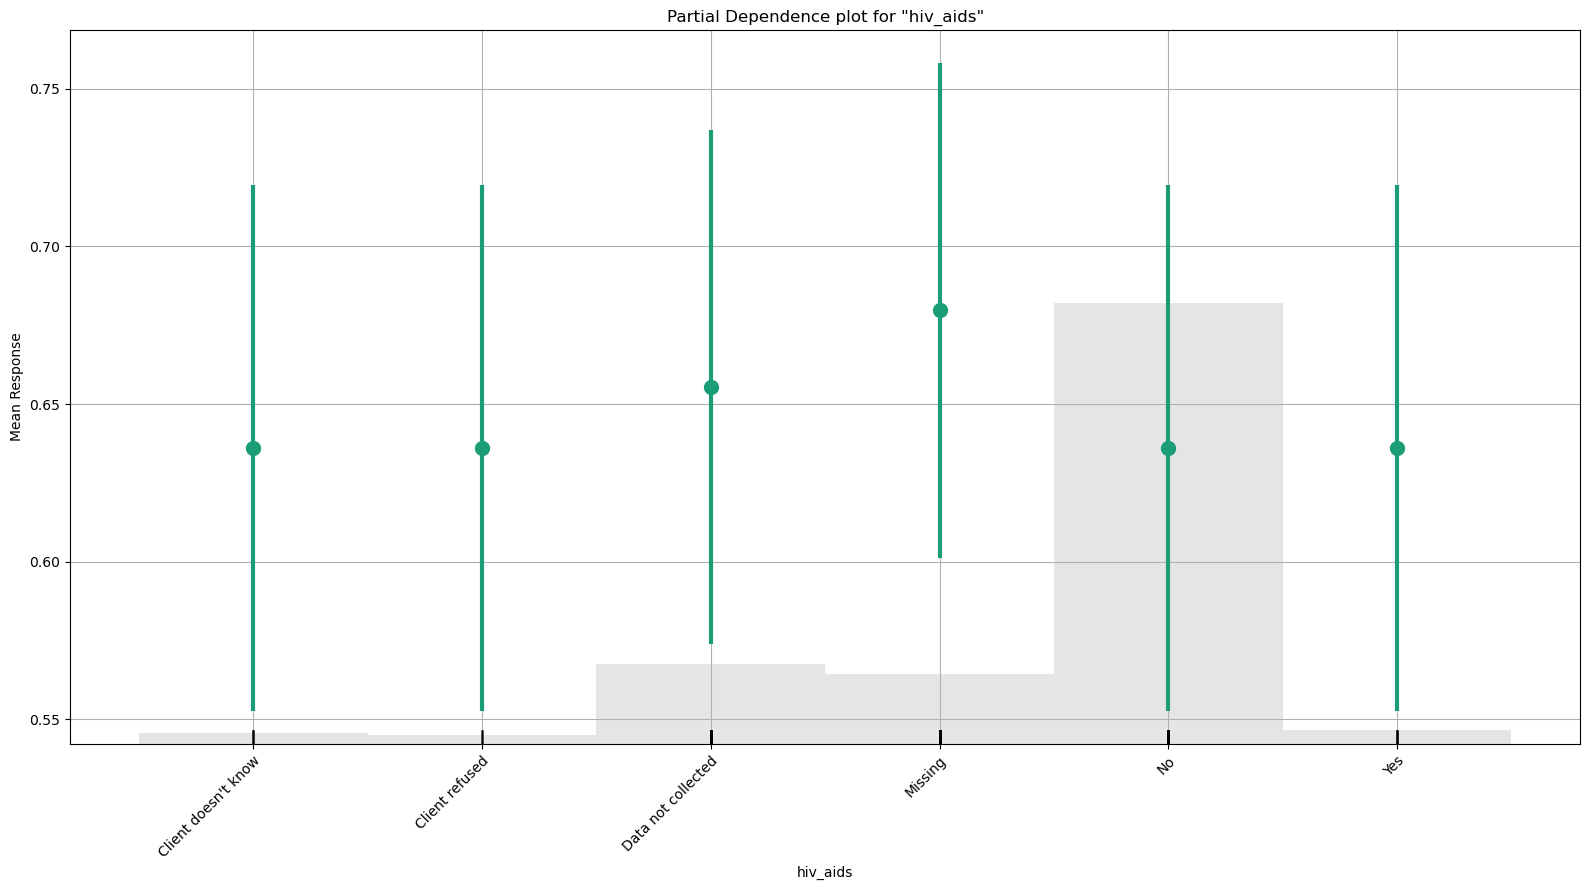

In [12]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

# If an instance of h2o is not started, start one, usually at https://localhost:54321
h2o.init()
# Read-in CSV with data cleansed and processed for modeling
df = pd.read_csv("../output/tls_recipients_2021_clean_for_model.csv")
# Convert from panda's dataframe to H2OFrame
data = h2o.H2OFrame(df)
# Split using h2o's frame method.
train, test = data.split_frame(ratios=[.7], seed=42)
# Instantiate a linear estimator of the binomial family
model = H2OGeneralizedLinearEstimator(family="binomial")
# Train model specifying the target variable and the predictor data
model.train(y="leased_up", training_frame=train)
# Predict on the test set
predictions = model.predict(test)
# Generate model explanation
model.explain(test, render=False)

# Model interpretation and Conclusion

The variable importance plot and the partial dependence plot for this model gives us a hint that there may be 3 groups of features that have a bearing on whether or not a client leases up:

1. Service provider
2. Living situation prior to TLS enrollment
3. Client's demographics

Service providers apparently can influence a client's ability to lease up, which demands that their operational params and processes should be studied separate from other variables, since it could come down to case workers, closeness to encampments, number of workers, their credentials, etc.

The influence of a client's current living situation prior to TLS enrollment may be clearer due to 2 possibilities: 3) the data comes from HMIS, and as a whole, this DB is a collection of elegibility and enrollment criteria, so data on a client's current status could be more reliable, since it is being collected for the purpose of program selection or enrollment; 2) the best predictor for the immediate future is the immediate past, so in reality, a client's current living situation may already be accounting for their transition to TLS-enabled housing, and 3) an already favorable entry living situation combined with an effective service provider smoothes and speeds up lease-up.

Finally, and to a lesser extent, a client's demographics have a moderate impact on lease-up, particularly race and if HIV/AIDS is not reported. This is structural, and we surmise it will have an impact in any type of model, regardless of other predictors that may be included along with these demographics.